# Git and Github

Installing git as we will use Github for tracking changes later once we have to collaborate.

In [ ]:
!apt-get install git

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.12).
0 upgraded, 0 newly installed, 0 to remove and 30 not upgraded.


In [ ]:
!git version

git version 2.34.1


Setting the git email and username so that commits can be tracked later. Important to know who made a particular commit. Please provide your own name and email here.

In [ ]:
!git config --global user.email "mrahman2410041@mscse.uiu.ac.bd"
!git config --global user.name "Md Ashiqur Rahman"

# Libraries

We will use the Pennylane library for the quantum components. I tried using the tensorflow quantum package but it creates a lot of dependency errors in google collab.

For the classical part, we will use the tensorflow package. I find it easier to understand compared to pytorch.

In [ ]:
!pip install tensorflow pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 46.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 55.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 95.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 94.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 115.5 MB/s eta 0:00:00


# Loading the necessary packages

This is required because Pennylane uses Keras 2 in its implementation. Whereas tensorflow defaults to keras 3.

In [ ]:
import os
os.environ['TF_USE_LEGACY_KERAS'] = '1'



In [ ]:
import tensorflow as tf
import pennylane as qml
from pennylane import numpy as np # Use PennyLane's wrapped numpy for compatibility
import matplotlib.pyplot as plt

# Hyperparameters

In [ ]:
# --- Hyperparameters ---
N_EPOCHS = 10          # Number of training epochs
BATCH_SIZE = 64        # Batch size for training
N_QUBITS = 4           # Number of qubits in the quantum circuit
Q_DEPTH = 2            # Number of layers in the quantum circuit's variational part
LEARNING_RATE = 0.001  # Learning rate for the optimizer


# Data Loading and Preprocessing

This step loads the necessary packages. More importantly it loads the data and does a quick check that everything is working as expected.

Loading MNIST dataset...
Dataset loaded.
Training data shape: (60000, 28, 28, 1)
Training labels shape: (60000,)
Test data shape: (10000, 28, 28, 1)
Test labels shape: (10000,)


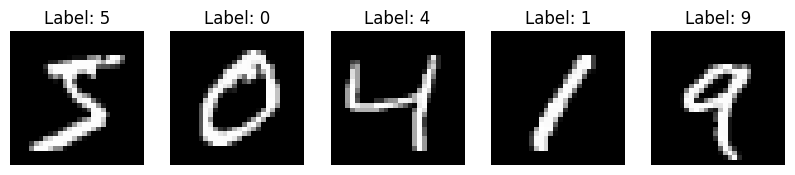

In [ ]:

# --- Data Loading ---
print("Loading MNIST dataset...")
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
print("Dataset loaded.")

# --- Preprocessing ---
# Normalize pixel values to be between 0 and 1
x_train = x_train / 255.0
x_test = x_test / 255.0

# Add channel dimension (required by Conv2D layers) -> (batch, height, width, channels)
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

# Use a smaller subset for faster demonstration/training

# N_TRAIN_SAMPLES = 5000
# N_TEST_SAMPLES = 1000

# if N_TRAIN_SAMPLES:
#  x_train, y_train = x_train[:N_TRAIN_SAMPLES], y_train[:N_TRAIN_SAMPLES]
# if N_TEST_SAMPLES:
#   x_test, y_test = x_test[:N_TEST_SAMPLES], y_test[:N_TEST_SAMPLES]

print(f"Training data shape: {x_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Test data shape: {x_test.shape}")
print(f"Test labels shape: {y_test.shape}")

# Visualize to check if data is loaded properly
plt.figure(figsize=(10, 2))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(x_train[i].reshape(28, 28), cmap="gray") # Reshape back for display
    plt.title(f"Label: {y_train[i]}")
    plt.axis("off")
plt.show()

# Classical Component: Feature Extraction CNN

Standard Keras layers

In [ ]:

def build_classical_part():
  """Builds the classical CNN layers for feature extraction."""
  model = tf.keras.models.Sequential([
      # Input Layer implicitly defined by the first layer's input shape
      tf.keras.layers.Conv2D(8, (3, 3), activation='relu', input_shape=(28, 28, 1)), # Output: (batch, 26, 26, 8)
      tf.keras.layers.MaxPooling2D((2, 2)), # Output: (batch, 13, 13, 8)

      tf.keras.layers.Conv2D(16, (3, 3), activation='relu'), # Output: (batch, 11, 11, 16)
      tf.keras.layers.MaxPooling2D((2, 2)), # Output: (batch, 5, 5, 16)

      tf.keras.layers.Flatten(), # Output: (batch, 5 * 5 * 16 = 400)
      # This Dense layer connects the classical features to the quantum circuit.
      # Its output dimension must match the number of inputs the quantum circuit expects.
      # Here, we design the quantum circuit to take N_QUBITS inputs.
      tf.keras.layers.Dense(N_QUBITS, activation='linear') # Output: (batch, N_QUBITS)
  ])
  return model

# Instantiate and view summary
classical_part = build_classical_part()
classical_part.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 8)         80        
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 8)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 16)        1168      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 16)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 400)               0         
                                                                 
 dense (Dense)               (None, 4)                 1

# Quantum Component

Quantum circuit and layer with Pennylane

In [ ]:


# --- Define Quantum Device ---
# Use 'default.qubit' and specify TensorFlow interface in the qnode decorator.
# wires=N_QUBITS specifies the number of qubits.
dev = qml.device("default.qubit", wires=N_QUBITS) # Use "default.qubit" instead of "default.qubit.tf"

# --- Define the Quantum Circuit (QNode) ---
# Ensure the decorator explicitly states the TensorFlow interface
@qml.qnode(dev, interface="tf", diff_method="backprop")
def quantum_circuit(inputs, weights):
    """
    Defines the quantum circuit structure.

    Args:
        inputs (tf.Tensor): Input features from the classical layer (shape=(N_QUBITS,)).
                           These will be used to encode data into the quantum state.
        weights (tf.Tensor): Trainable parameters (weights) for the quantum circuit
                             (shape=(Q_DEPTH, N_QUBITS)).
    Returns:
        tf.Tensor: Expectation values of Pauli Z measurements on each qubit (shape=(N_QUBITS,)).
    """
    # 1. Encoding Layer: Embed classical data into the quantum state.
    qml.AngleEmbedding(inputs, wires=range(N_QUBITS))

    # 2. Variational/Entangling Layers: Apply layers of trainable gates.
    for i in range(Q_DEPTH):
        # Apply single-qubit rotation gates (parameterized)
        for j in range(N_QUBITS):
            qml.RY(weights[i, j], wires=j)

        # Apply entangling gates (CNOTs)
        for j in range(N_QUBITS - 1):
            qml.CNOT(wires=[j, j + 1])
        # Optional: Add a CNOT connecting the last and first qubit for circular entanglement
        # qml.CNOT(wires=[N_QUBITS - 1, 0])

    # 3. Measurement: Extract classical information from the quantum state.
    return [qml.expval(qml.PauliZ(i)) for i in range(N_QUBITS)]

# --- Define Weight Shapes for the Quantum Layer ---
# The KerasLayer needs to know the shapes of the trainable weights used in the qnode.
weight_shapes = {"weights": (Q_DEPTH, N_QUBITS)}

# --- Create the Quantum Keras Layer ---
# This layer wraps the QNode, making it compatible with Keras models.
quantum_layer = qml.qnn.KerasLayer(quantum_circuit, weight_shapes, output_dim=N_QUBITS)

# --- Test the Quantum Layer (Optional) ---
# Create some dummy input and weights to see the output shape
dummy_input = tf.random.uniform(shape=(1, N_QUBITS)) # Batch size 1
# Make sure weights are created correctly for testing shape consistency
dummy_keras_layer_weights = {'weights': tf.random.uniform(shape=weight_shapes['weights'])}
# The KerasLayer manages its own weights, so we pass input directly
result = quantum_layer(dummy_input)
print(f"Quantum layer input shape: {dummy_input.shape}")
print(f"Quantum layer output shape: {result.shape}") # Should be (batch_size, N_QUBITS)

Quantum layer input shape: (1, 4)
Quantum layer output shape: (1, 4)


# Assembling the hybrid model

Combining the classical and quantum part. Adding a final classical layer for classification.

In [ ]:


def build_hybrid_model():
  """Builds the complete Hybrid Quantum-Classical CNN."""
  # Start with the classical feature extraction part
  classical_model_part = build_classical_part()

  # Define the final classical layer for classification
  # Takes the N_QUBITS outputs from the quantum layer
  # Outputs 10 probabilities (for digits 0-9) using softmax activation
  final_classifier = tf.keras.models.Sequential([
      tf.keras.layers.Dense(10, activation="softmax") # Output: (batch, 10)
  ])

  # Combine classical part -> quantum layer -> final classifier
  model = tf.keras.models.Sequential([
      classical_model_part,
      quantum_layer,
      # Add a Lambda layer to explicitly cast the output of quantum_layer
      # This ensures the input to the final classifier is float32
      # and suppresses the complex128->float32 warning.
      tf.keras.layers.Lambda(lambda x: tf.cast(tf.math.real(x), dtype=tf.float32), name="cast_to_float32"),
      final_classifier
  ])

  return model

hybrid_model = build_hybrid_model()

# --- Compile the Model ---
# Compile the model specifying the optimizer, loss function, and metrics.
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
hybrid_model.compile(optimizer=optimizer,
                     loss="sparse_categorical_crossentropy", # Use because labels are integers
                     metrics=["accuracy"])

# --- Print Model Summary ---
# This summary shows all layers, output shapes, and parameter counts.
# Note the parameters in the 'keras_layer' (our quantum layer).
hybrid_model.build(input_shape=(None, 28, 28, 1)) # Build the model to inspect summary properly
hybrid_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 4)                 2852      
                                                                 
 keras_layer (KerasLayer)    (None, 4)                 8         
                                                                 
 cast_to_float32 (Lambda)    (None, 4)                 0         
                                                                 
 sequential_2 (Sequential)   (None, 10)                50        
                                                                 
Total params: 2910 (11.37 KB)
Trainable params: 2910 (11.37 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Training the HQCNN

In [ ]:


print("\n--- Starting Training ---")

# Train the model
# x_train, y_train: Training data and labels
# epochs: Number of times to iterate over the entire training dataset
# batch_size: Number of samples per gradient update
# validation_data: Data on which to evaluate the loss and any model metrics at the end of each epoch.
#                  The model is not trained on this data.
history = hybrid_model.fit(x_train, y_train,
                           epochs=N_EPOCHS,
                           batch_size=BATCH_SIZE,
                           validation_data=(x_test, y_test), # Use test set for validation here
                           verbose=1) # Show progress bar

print("--- Training Finished ---")

# --- Plot Training History ---
def plot_history(history):
    plt.figure(figsize=(12, 4))

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

plot_history(history)


--- Starting Training ---
Epoch 1/10


  1/938 [..............................] - ETA: 3:45 - loss: 0.9913 - accuracy: 0.7500

  2/938 [..............................] - ETA: 3:52 - loss: 0.9658 - accuracy: 0.7422

  3/938 [..............................] - ETA: 3:42 - loss: 0.9377 - accuracy: 0.7708

  4/938 [..............................] - ETA: 3:40 - loss: 0.9427 - accuracy: 0.7617

  5/938 [..............................] - ETA: 3:41 - loss: 0.9244 - accuracy: 0.7844

  6/938 [..............................] - ETA: 3:41 - loss: 0.9253 - accuracy: 0.7839

  7/938 [..............................] - ETA: 3:42 - loss: 0.9443 - accuracy: 0.7835

  8/938 [..............................] - ETA: 3:42 - loss: 0.9219 - accuracy: 0.7930

  9/938 [..............................] - ETA: 3:43 - loss: 0.9136 - accuracy: 0.7969

 10/938 [..............................] - ETA: 3:43 - loss: 0.9169 - accuracy: 0.7922

 11/938 [..............................] - ETA: 3:44 - loss: 0.9158 - accuracy: 0.7884

 12/938 [..............................] - ETA: 3:43 - loss: 0.9072 - accuracy: 0.7930

 13/938 [..............................] - ETA: 3:43 - loss: 0.9021 - accuracy: 0.7969

 14/938 [..............................] - ETA: 3:43 - loss: 0.9025 - accuracy: 0.7935

 15/938 [..............................] - ETA: 3:43 - loss: 0.9114 - accuracy: 0.7875

 16/938 [..............................] - ETA: 3:43 - loss: 0.9069 - accuracy: 0.7910

 17/938 [..............................] - ETA: 3:43 - loss: 0.9044 - accuracy: 0.7877

 18/938 [..............................] - ETA: 3:43 - loss: 0.9015 - accuracy: 0.7891

 19/938 [..............................] - ETA: 3:43 - loss: 0.8996 - accuracy: 0.7895

 20/938 [..............................] - ETA: 3:43 - loss: 0.9001 - accuracy: 0.7898

 21/938 [..............................] - ETA: 3:42 - loss: 0.8989 - accuracy: 0.7932

 22/938 [..............................] - ETA: 3:42 - loss: 0.8938 - accuracy: 0.7976

 23/938 [..............................] - ETA: 3:43 - loss: 0.8969 - accuracy: 0.7955

 24/938 [..............................] - ETA: 3:43 - loss: 0.8963 - accuracy: 0.8001

 25/938 [..............................] - ETA: 3:43 - loss: 0.9057 - accuracy: 0.7956

 26/938 [..............................] - ETA: 3:42 - loss: 0.9083 - accuracy: 0.7957

 27/938 [..............................] - ETA: 3:42 - loss: 0.9070 - accuracy: 0.7963

 28/938 [..............................] - ETA: 3:43 - loss: 0.9085 - accuracy: 0.7980

 29/938 [..............................] - ETA: 3:42 - loss: 0.9122 - accuracy: 0.7958

 30/938 [..............................] - ETA: 3:42 - loss: 0.9138 - accuracy: 0.7958

 31/938 [..............................] - ETA: 3:42 - loss: 0.9160 - accuracy: 0.7954

 32/938 [>.............................] - ETA: 3:42 - loss: 0.9184 - accuracy: 0.7944

 33/938 [>.............................] - ETA: 3:42 - loss: 0.9161 - accuracy: 0.7955

 34/938 [>.............................] - ETA: 3:45 - loss: 0.9200 - accuracy: 0.7937

 35/938 [>.............................] - ETA: 3:47 - loss: 0.9202 - accuracy: 0.7933

 36/938 [>.............................] - ETA: 3:48 - loss: 0.9170 - accuracy: 0.7943

 37/938 [>.............................] - ETA: 3:50 - loss: 0.9159 - accuracy: 0.7943

 38/938 [>.............................] - ETA: 3:51 - loss: 0.9138 - accuracy: 0.7952

 39/938 [>.............................] - ETA: 3:53 - loss: 0.9128 - accuracy: 0.7961

 40/938 [>.............................] - ETA: 3:55 - loss: 0.9131 - accuracy: 0.7961

 41/938 [>.............................] - ETA: 3:57 - loss: 0.9128 - accuracy: 0.7954

 42/938 [>.............................] - ETA: 3:56 - loss: 0.9120 - accuracy: 0.7961

 43/938 [>.............................] - ETA: 3:56 - loss: 0.9106 - accuracy: 0.7976

 44/938 [>.............................] - ETA: 3:56 - loss: 0.9096 - accuracy: 0.7979

 45/938 [>.............................] - ETA: 3:56 - loss: 0.9096 - accuracy: 0.7983

 46/938 [>.............................] - ETA: 3:55 - loss: 0.9107 - accuracy: 0.7972

 47/938 [>.............................] - ETA: 3:55 - loss: 0.9094 - accuracy: 0.7982

 48/938 [>.............................] - ETA: 3:55 - loss: 0.9095 - accuracy: 0.7985

 49/938 [>.............................] - ETA: 3:55 - loss: 0.9099 - accuracy: 0.7982

 50/938 [>.............................] - ETA: 3:56 - loss: 0.9098 - accuracy: 0.7978

 51/938 [>.............................] - ETA: 3:56 - loss: 0.9112 - accuracy: 0.7963

 52/938 [>.............................] - ETA: 3:55 - loss: 0.9099 - accuracy: 0.7975

 53/938 [>.............................] - ETA: 3:55 - loss: 0.9076 - accuracy: 0.7989

 54/938 [>.............................] - ETA: 3:56 - loss: 0.9073 - accuracy: 0.7980

 55/938 [>.............................] - ETA: 4:01 - loss: 0.9092 - accuracy: 0.7972

 56/938 [>.............................] - ETA: 4:01 - loss: 0.9103 - accuracy: 0.7960

 57/938 [>.............................] - ETA: 4:01 - loss: 0.9090 - accuracy: 0.7966

 58/938 [>.............................] - ETA: 4:00 - loss: 0.9074 - accuracy: 0.7980

 59/938 [>.............................] - ETA: 4:00 - loss: 0.9050 - accuracy: 0.7990

 60/938 [>.............................] - ETA: 3:59 - loss: 0.9030 - accuracy: 0.7997

 61/938 [>.............................] - ETA: 3:59 - loss: 0.9022 - accuracy: 0.7999

 62/938 [>.............................] - ETA: 3:59 - loss: 0.9015 - accuracy: 0.7996

 63/938 [=>............................] - ETA: 3:58 - loss: 0.9019 - accuracy: 0.8001

 64/938 [=>............................] - ETA: 3:58 - loss: 0.9020 - accuracy: 0.8003

 65/938 [=>............................] - ETA: 3:58 - loss: 0.9011 - accuracy: 0.8012

 66/938 [=>............................] - ETA: 3:58 - loss: 0.8995 - accuracy: 0.8016

 67/938 [=>............................] - ETA: 3:57 - loss: 0.8998 - accuracy: 0.8011

 68/938 [=>............................] - ETA: 3:57 - loss: 0.8985 - accuracy: 0.8008

 69/938 [=>............................] - ETA: 3:57 - loss: 0.8971 - accuracy: 0.8014

 70/938 [=>............................] - ETA: 3:57 - loss: 0.8964 - accuracy: 0.8016

 71/938 [=>............................] - ETA: 3:57 - loss: 0.8953 - accuracy: 0.8022

 72/938 [=>............................] - ETA: 3:56 - loss: 0.8945 - accuracy: 0.8021

 73/938 [=>............................] - ETA: 3:56 - loss: 0.8944 - accuracy: 0.8022

 74/938 [=>............................] - ETA: 3:56 - loss: 0.8937 - accuracy: 0.8028

 75/938 [=>............................] - ETA: 3:55 - loss: 0.8943 - accuracy: 0.8017

 76/938 [=>............................] - ETA: 3:55 - loss: 0.8949 - accuracy: 0.8008

 77/938 [=>............................] - ETA: 3:56 - loss: 0.8953 - accuracy: 0.8003

 78/938 [=>............................] - ETA: 3:56 - loss: 0.8938 - accuracy: 0.8007

 79/938 [=>............................] - ETA: 3:57 - loss: 0.8933 - accuracy: 0.8012

 80/938 [=>............................] - ETA: 3:58 - loss: 0.8916 - accuracy: 0.8025

 81/938 [=>............................] - ETA: 3:58 - loss: 0.8917 - accuracy: 0.8025

 82/938 [=>............................] - ETA: 3:59 - loss: 0.8915 - accuracy: 0.8026

 83/938 [=>............................] - ETA: 3:59 - loss: 0.8913 - accuracy: 0.8020

 84/938 [=>............................] - ETA: 4:00 - loss: 0.8914 - accuracy: 0.8013

 85/938 [=>............................] - ETA: 4:01 - loss: 0.8895 - accuracy: 0.8018

 86/938 [=>............................] - ETA: 4:01 - loss: 0.8888 - accuracy: 0.8020

 87/938 [=>............................] - ETA: 4:01 - loss: 0.8891 - accuracy: 0.8019

 88/938 [=>............................] - ETA: 4:00 - loss: 0.8882 - accuracy: 0.8020

 89/938 [=>............................] - ETA: 4:00 - loss: 0.8882 - accuracy: 0.8014

 90/938 [=>............................] - ETA: 4:00 - loss: 0.8881 - accuracy: 0.8016

 91/938 [=>............................] - ETA: 3:59 - loss: 0.8887 - accuracy: 0.8013

 92/938 [=>............................] - ETA: 3:59 - loss: 0.8883 - accuracy: 0.8010

 93/938 [=>............................] - ETA: 3:59 - loss: 0.8887 - accuracy: 0.8001

 94/938 [==>...........................] - ETA: 3:59 - loss: 0.8886 - accuracy: 0.8000

 95/938 [==>...........................] - ETA: 3:59 - loss: 0.8877 - accuracy: 0.7997

 96/938 [==>...........................] - ETA: 3:58 - loss: 0.8879 - accuracy: 0.7993

 97/938 [==>...........................] - ETA: 3:58 - loss: 0.8873 - accuracy: 0.7999

 98/938 [==>...........................] - ETA: 3:58 - loss: 0.8870 - accuracy: 0.8001

 99/938 [==>...........................] - ETA: 3:58 - loss: 0.8866 - accuracy: 0.7999

100/938 [==>...........................] - ETA: 3:58 - loss: 0.8854 - accuracy: 0.8006

101/938 [==>...........................] - ETA: 3:58 - loss: 0.8849 - accuracy: 0.8009

102/938 [==>...........................] - ETA: 3:57 - loss: 0.8835 - accuracy: 0.8016

103/938 [==>...........................] - ETA: 3:59 - loss: 0.8834 - accuracy: 0.8011

104/938 [==>...........................] - ETA: 4:00 - loss: 0.8828 - accuracy: 0.8018

105/938 [==>...........................] - ETA: 4:00 - loss: 0.8809 - accuracy: 0.8024

106/938 [==>...........................] - ETA: 3:59 - loss: 0.8800 - accuracy: 0.8026

107/938 [==>...........................] - ETA: 3:59 - loss: 0.8794 - accuracy: 0.8027

108/938 [==>...........................] - ETA: 3:59 - loss: 0.8790 - accuracy: 0.8027

109/938 [==>...........................] - ETA: 3:59 - loss: 0.8789 - accuracy: 0.8032

110/938 [==>...........................] - ETA: 3:58 - loss: 0.8782 - accuracy: 0.8031

111/938 [==>...........................] - ETA: 3:58 - loss: 0.8783 - accuracy: 0.8026

112/938 [==>...........................] - ETA: 3:58 - loss: 0.8769 - accuracy: 0.8032

113/938 [==>...........................] - ETA: 3:58 - loss: 0.8758 - accuracy: 0.8038

114/938 [==>...........................] - ETA: 3:57 - loss: 0.8768 - accuracy: 0.8035

115/938 [==>...........................] - ETA: 3:57 - loss: 0.8775 - accuracy: 0.8033

116/938 [==>...........................] - ETA: 3:57 - loss: 0.8777 - accuracy: 0.8032

117/938 [==>...........................] - ETA: 3:56 - loss: 0.8780 - accuracy: 0.8026

118/938 [==>...........................] - ETA: 3:56 - loss: 0.8776 - accuracy: 0.8027

119/938 [==>...........................] - ETA: 3:57 - loss: 0.8782 - accuracy: 0.8027

120/938 [==>...........................] - ETA: 3:57 - loss: 0.8779 - accuracy: 0.8031

121/938 [==>...........................] - ETA: 3:57 - loss: 0.8776 - accuracy: 0.8029

122/938 [==>...........................] - ETA: 3:57 - loss: 0.8776 - accuracy: 0.8034

123/938 [==>...........................] - ETA: 3:57 - loss: 0.8772 - accuracy: 0.8035

124/938 [==>...........................] - ETA: 3:57 - loss: 0.8766 - accuracy: 0.8038

125/938 [==>...........................] - ETA: 3:56 - loss: 0.8754 - accuracy: 0.8041

126/938 [===>..........................] - ETA: 3:56 - loss: 0.8762 - accuracy: 0.8033

127/938 [===>..........................] - ETA: 3:57 - loss: 0.8763 - accuracy: 0.8030

128/938 [===>..........................] - ETA: 3:57 - loss: 0.8764 - accuracy: 0.8030

129/938 [===>..........................] - ETA: 3:57 - loss: 0.8765 - accuracy: 0.8031

130/938 [===>..........................] - ETA: 3:57 - loss: 0.8762 - accuracy: 0.8030

131/938 [===>..........................] - ETA: 3:57 - loss: 0.8764 - accuracy: 0.8025

132/938 [===>..........................] - ETA: 3:57 - loss: 0.8767 - accuracy: 0.8028

133/938 [===>..........................] - ETA: 3:57 - loss: 0.8757 - accuracy: 0.8031

134/938 [===>..........................] - ETA: 3:57 - loss: 0.8756 - accuracy: 0.8034

135/938 [===>..........................] - ETA: 3:56 - loss: 0.8762 - accuracy: 0.8030

136/938 [===>..........................] - ETA: 3:56 - loss: 0.8761 - accuracy: 0.8028

137/938 [===>..........................] - ETA: 3:56 - loss: 0.8760 - accuracy: 0.8029

138/938 [===>..........................] - ETA: 3:56 - loss: 0.8746 - accuracy: 0.8036

139/938 [===>..........................] - ETA: 3:55 - loss: 0.8739 - accuracy: 0.8038

140/938 [===>..........................] - ETA: 3:55 - loss: 0.8739 - accuracy: 0.8037

141/938 [===>..........................] - ETA: 3:55 - loss: 0.8743 - accuracy: 0.8037

142/938 [===>..........................] - ETA: 3:55 - loss: 0.8740 - accuracy: 0.8040

143/938 [===>..........................] - ETA: 3:54 - loss: 0.8749 - accuracy: 0.8038

144/938 [===>..........................] - ETA: 3:54 - loss: 0.8746 - accuracy: 0.8038

145/938 [===>..........................] - ETA: 3:54 - loss: 0.8738 - accuracy: 0.8041

146/938 [===>..........................] - ETA: 3:54 - loss: 0.8735 - accuracy: 0.8038

147/938 [===>..........................] - ETA: 3:54 - loss: 0.8730 - accuracy: 0.8044

148/938 [===>..........................] - ETA: 3:54 - loss: 0.8723 - accuracy: 0.8047

149/938 [===>..........................] - ETA: 3:53 - loss: 0.8729 - accuracy: 0.8040

150/938 [===>..........................] - ETA: 3:53 - loss: 0.8732 - accuracy: 0.8036

151/938 [===>..........................] - ETA: 3:53 - loss: 0.8728 - accuracy: 0.8036

152/938 [===>..........................] - ETA: 3:53 - loss: 0.8718 - accuracy: 0.8044

153/938 [===>..........................] - ETA: 3:52 - loss: 0.8718 - accuracy: 0.8042

154/938 [===>..........................] - ETA: 3:52 - loss: 0.8718 - accuracy: 0.8042

155/938 [===>..........................] - ETA: 3:52 - loss: 0.8710 - accuracy: 0.8042

156/938 [===>..........................] - ETA: 3:52 - loss: 0.8702 - accuracy: 0.8044

157/938 [====>.........................] - ETA: 3:52 - loss: 0.8691 - accuracy: 0.8049

158/938 [====>.........................] - ETA: 3:52 - loss: 0.8689 - accuracy: 0.8053

159/938 [====>.........................] - ETA: 3:51 - loss: 0.8682 - accuracy: 0.8055

160/938 [====>.........................] - ETA: 3:51 - loss: 0.8686 - accuracy: 0.8052

161/938 [====>.........................] - ETA: 3:51 - loss: 0.8686 - accuracy: 0.8052

162/938 [====>.........................] - ETA: 3:51 - loss: 0.8683 - accuracy: 0.8052

163/938 [====>.........................] - ETA: 3:51 - loss: 0.8673 - accuracy: 0.8055

164/938 [====>.........................] - ETA: 3:51 - loss: 0.8671 - accuracy: 0.8054

165/938 [====>.........................] - ETA: 3:51 - loss: 0.8670 - accuracy: 0.8053

166/938 [====>.........................] - ETA: 3:51 - loss: 0.8670 - accuracy: 0.8048

167/938 [====>.........................] - ETA: 3:51 - loss: 0.8671 - accuracy: 0.8047

168/938 [====>.........................] - ETA: 3:51 - loss: 0.8670 - accuracy: 0.8049

169/938 [====>.........................] - ETA: 3:51 - loss: 0.8670 - accuracy: 0.8049

170/938 [====>.........................] - ETA: 3:51 - loss: 0.8666 - accuracy: 0.8051

171/938 [====>.........................] - ETA: 3:51 - loss: 0.8659 - accuracy: 0.8052

172/938 [====>.........................] - ETA: 3:51 - loss: 0.8655 - accuracy: 0.8054

173/938 [====>.........................] - ETA: 3:51 - loss: 0.8651 - accuracy: 0.8057

174/938 [====>.........................] - ETA: 3:51 - loss: 0.8643 - accuracy: 0.8059

175/938 [====>.........................] - ETA: 3:53 - loss: 0.8641 - accuracy: 0.8059

176/938 [====>.........................] - ETA: 3:53 - loss: 0.8642 - accuracy: 0.8058

177/938 [====>.........................] - ETA: 3:53 - loss: 0.8637 - accuracy: 0.8061

178/938 [====>.........................] - ETA: 3:53 - loss: 0.8632 - accuracy: 0.8065

179/938 [====>.........................] - ETA: 3:52 - loss: 0.8624 - accuracy: 0.8069

180/938 [====>.........................] - ETA: 3:52 - loss: 0.8627 - accuracy: 0.8066

181/938 [====>.........................] - ETA: 3:52 - loss: 0.8626 - accuracy: 0.8063

182/938 [====>.........................] - ETA: 3:51 - loss: 0.8618 - accuracy: 0.8064

183/938 [====>.........................] - ETA: 3:51 - loss: 0.8608 - accuracy: 0.8067

184/938 [====>.........................] - ETA: 3:51 - loss: 0.8600 - accuracy: 0.8070

185/938 [====>.........................] - ETA: 3:51 - loss: 0.8597 - accuracy: 0.8070

186/938 [====>.........................] - ETA: 3:50 - loss: 0.8597 - accuracy: 0.8072

187/938 [====>.........................] - ETA: 3:50 - loss: 0.8598 - accuracy: 0.8070

188/938 [=====>........................] - ETA: 3:50 - loss: 0.8593 - accuracy: 0.8072

189/938 [=====>........................] - ETA: 3:50 - loss: 0.8588 - accuracy: 0.8075

190/938 [=====>........................] - ETA: 3:49 - loss: 0.8582 - accuracy: 0.8077

191/938 [=====>........................] - ETA: 3:49 - loss: 0.8574 - accuracy: 0.8083

192/938 [=====>........................] - ETA: 3:49 - loss: 0.8570 - accuracy: 0.8083

193/938 [=====>........................] - ETA: 3:49 - loss: 0.8564 - accuracy: 0.8086

194/938 [=====>........................] - ETA: 3:48 - loss: 0.8562 - accuracy: 0.8086

195/938 [=====>........................] - ETA: 3:48 - loss: 0.8561 - accuracy: 0.8084

196/938 [=====>........................] - ETA: 3:48 - loss: 0.8560 - accuracy: 0.8084

197/938 [=====>........................] - ETA: 3:47 - loss: 0.8557 - accuracy: 0.8085

198/938 [=====>........................] - ETA: 3:47 - loss: 0.8553 - accuracy: 0.8084

199/938 [=====>........................] - ETA: 3:47 - loss: 0.8558 - accuracy: 0.8083

200/938 [=====>........................] - ETA: 3:47 - loss: 0.8553 - accuracy: 0.8085

201/938 [=====>........................] - ETA: 3:47 - loss: 0.8552 - accuracy: 0.8082

202/938 [=====>........................] - ETA: 3:47 - loss: 0.8551 - accuracy: 0.8082

203/938 [=====>........................] - ETA: 3:47 - loss: 0.8549 - accuracy: 0.8083

204/938 [=====>........................] - ETA: 3:46 - loss: 0.8544 - accuracy: 0.8084

205/938 [=====>........................] - ETA: 3:46 - loss: 0.8541 - accuracy: 0.8084

206/938 [=====>........................] - ETA: 3:46 - loss: 0.8544 - accuracy: 0.8077

207/938 [=====>........................] - ETA: 3:46 - loss: 0.8553 - accuracy: 0.8074

208/938 [=====>........................] - ETA: 3:46 - loss: 0.8549 - accuracy: 0.8075

209/938 [=====>........................] - ETA: 3:46 - loss: 0.8542 - accuracy: 0.8078

210/938 [=====>........................] - ETA: 3:46 - loss: 0.8535 - accuracy: 0.8081

211/938 [=====>........................] - ETA: 3:46 - loss: 0.8538 - accuracy: 0.8080

212/938 [=====>........................] - ETA: 3:45 - loss: 0.8539 - accuracy: 0.8075

213/938 [=====>........................] - ETA: 3:45 - loss: 0.8538 - accuracy: 0.8071

214/938 [=====>........................] - ETA: 3:45 - loss: 0.8535 - accuracy: 0.8072

215/938 [=====>........................] - ETA: 3:44 - loss: 0.8538 - accuracy: 0.8070

216/938 [=====>........................] - ETA: 3:44 - loss: 0.8543 - accuracy: 0.8065

217/938 [=====>........................] - ETA: 3:44 - loss: 0.8537 - accuracy: 0.8066

218/938 [=====>........................] - ETA: 3:44 - loss: 0.8533 - accuracy: 0.8065

219/938 [======>.......................] - ETA: 3:43 - loss: 0.8529 - accuracy: 0.8067

220/938 [======>.......................] - ETA: 3:43 - loss: 0.8524 - accuracy: 0.8067

221/938 [======>.......................] - ETA: 3:43 - loss: 0.8525 - accuracy: 0.8064

222/938 [======>.......................] - ETA: 3:42 - loss: 0.8520 - accuracy: 0.8062

223/938 [======>.......................] - ETA: 3:42 - loss: 0.8515 - accuracy: 0.8064

224/938 [======>.......................] - ETA: 3:42 - loss: 0.8514 - accuracy: 0.8060

225/938 [======>.......................] - ETA: 3:42 - loss: 0.8517 - accuracy: 0.8058

226/938 [======>.......................] - ETA: 3:41 - loss: 0.8514 - accuracy: 0.8060

227/938 [======>.......................] - ETA: 3:41 - loss: 0.8510 - accuracy: 0.8059

228/938 [======>.......................] - ETA: 3:41 - loss: 0.8507 - accuracy: 0.8060

229/938 [======>.......................] - ETA: 3:40 - loss: 0.8504 - accuracy: 0.8058

230/938 [======>.......................] - ETA: 3:40 - loss: 0.8501 - accuracy: 0.8059

231/938 [======>.......................] - ETA: 3:40 - loss: 0.8495 - accuracy: 0.8061

232/938 [======>.......................] - ETA: 3:39 - loss: 0.8488 - accuracy: 0.8064

233/938 [======>.......................] - ETA: 3:39 - loss: 0.8485 - accuracy: 0.8067

234/938 [======>.......................] - ETA: 3:39 - loss: 0.8477 - accuracy: 0.8070

235/938 [======>.......................] - ETA: 3:38 - loss: 0.8475 - accuracy: 0.8069

236/938 [======>.......................] - ETA: 3:38 - loss: 0.8474 - accuracy: 0.8069

237/938 [======>.......................] - ETA: 3:38 - loss: 0.8472 - accuracy: 0.8069

238/938 [======>.......................] - ETA: 3:37 - loss: 0.8472 - accuracy: 0.8068

239/938 [======>.......................] - ETA: 3:37 - loss: 0.8465 - accuracy: 0.8069

240/938 [======>.......................] - ETA: 3:37 - loss: 0.8461 - accuracy: 0.8072

241/938 [======>.......................] - ETA: 3:37 - loss: 0.8459 - accuracy: 0.8073

242/938 [======>.......................] - ETA: 3:37 - loss: 0.8463 - accuracy: 0.8070

243/938 [======>.......................] - ETA: 3:36 - loss: 0.8455 - accuracy: 0.8072

244/938 [======>.......................] - ETA: 3:36 - loss: 0.8449 - accuracy: 0.8075

245/938 [======>.......................] - ETA: 3:37 - loss: 0.8452 - accuracy: 0.8071

246/938 [======>.......................] - ETA: 3:38 - loss: 0.8448 - accuracy: 0.8070

247/938 [======>.......................] - ETA: 3:38 - loss: 0.8445 - accuracy: 0.8071

248/938 [======>.......................] - ETA: 3:38 - loss: 0.8438 - accuracy: 0.8074

249/938 [======>.......................] - ETA: 3:38 - loss: 0.8439 - accuracy: 0.8071

250/938 [======>.......................] - ETA: 3:38 - loss: 0.8433 - accuracy: 0.8074

251/938 [=======>......................] - ETA: 3:37 - loss: 0.8433 - accuracy: 0.8073

252/938 [=======>......................] - ETA: 3:37 - loss: 0.8431 - accuracy: 0.8074

253/938 [=======>......................] - ETA: 3:37 - loss: 0.8429 - accuracy: 0.8074

254/938 [=======>......................] - ETA: 3:36 - loss: 0.8428 - accuracy: 0.8074

255/938 [=======>......................] - ETA: 3:36 - loss: 0.8428 - accuracy: 0.8072

256/938 [=======>......................] - ETA: 3:36 - loss: 0.8423 - accuracy: 0.8077

257/938 [=======>......................] - ETA: 3:36 - loss: 0.8421 - accuracy: 0.8075

258/938 [=======>......................] - ETA: 3:35 - loss: 0.8417 - accuracy: 0.8075

259/938 [=======>......................] - ETA: 3:35 - loss: 0.8413 - accuracy: 0.8076

260/938 [=======>......................] - ETA: 3:35 - loss: 0.8411 - accuracy: 0.8077

261/938 [=======>......................] - ETA: 3:34 - loss: 0.8410 - accuracy: 0.8077

262/938 [=======>......................] - ETA: 3:34 - loss: 0.8403 - accuracy: 0.8080

263/938 [=======>......................] - ETA: 3:34 - loss: 0.8404 - accuracy: 0.8079

264/938 [=======>......................] - ETA: 3:34 - loss: 0.8401 - accuracy: 0.8079

265/938 [=======>......................] - ETA: 3:33 - loss: 0.8398 - accuracy: 0.8081

266/938 [=======>......................] - ETA: 3:33 - loss: 0.8397 - accuracy: 0.8079

267/938 [=======>......................] - ETA: 3:33 - loss: 0.8394 - accuracy: 0.8076

268/938 [=======>......................] - ETA: 3:32 - loss: 0.8395 - accuracy: 0.8074

269/938 [=======>......................] - ETA: 3:32 - loss: 0.8392 - accuracy: 0.8074

270/938 [=======>......................] - ETA: 3:32 - loss: 0.8386 - accuracy: 0.8076

271/938 [=======>......................] - ETA: 3:33 - loss: 0.8379 - accuracy: 0.8078

272/938 [=======>......................] - ETA: 3:34 - loss: 0.8378 - accuracy: 0.8080

273/938 [=======>......................] - ETA: 3:34 - loss: 0.8379 - accuracy: 0.8079

274/938 [=======>......................] - ETA: 3:33 - loss: 0.8375 - accuracy: 0.8080

275/938 [=======>......................] - ETA: 3:33 - loss: 0.8369 - accuracy: 0.8080

276/938 [=======>......................] - ETA: 3:33 - loss: 0.8364 - accuracy: 0.8079

277/938 [=======>......................] - ETA: 3:32 - loss: 0.8364 - accuracy: 0.8078

278/938 [=======>......................] - ETA: 3:32 - loss: 0.8365 - accuracy: 0.8076

279/938 [=======>......................] - ETA: 3:32 - loss: 0.8360 - accuracy: 0.8078

280/938 [=======>......................] - ETA: 3:32 - loss: 0.8357 - accuracy: 0.8076

281/938 [=======>......................] - ETA: 3:32 - loss: 0.8356 - accuracy: 0.8076

282/938 [========>.....................] - ETA: 3:32 - loss: 0.8357 - accuracy: 0.8074

283/938 [========>.....................] - ETA: 3:31 - loss: 0.8353 - accuracy: 0.8075

284/938 [========>.....................] - ETA: 3:31 - loss: 0.8351 - accuracy: 0.8074

285/938 [========>.....................] - ETA: 3:32 - loss: 0.8348 - accuracy: 0.8073

286/938 [========>.....................] - ETA: 3:32 - loss: 0.8345 - accuracy: 0.8074

287/938 [========>.....................] - ETA: 3:32 - loss: 0.8342 - accuracy: 0.8074

288/938 [========>.....................] - ETA: 3:32 - loss: 0.8340 - accuracy: 0.8074

289/938 [========>.....................] - ETA: 3:31 - loss: 0.8335 - accuracy: 0.8075

290/938 [========>.....................] - ETA: 3:31 - loss: 0.8337 - accuracy: 0.8073

291/938 [========>.....................] - ETA: 3:30 - loss: 0.8338 - accuracy: 0.8070

292/938 [========>.....................] - ETA: 3:30 - loss: 0.8339 - accuracy: 0.8069

293/938 [========>.....................] - ETA: 3:30 - loss: 0.8341 - accuracy: 0.8066

294/938 [========>.....................] - ETA: 3:29 - loss: 0.8338 - accuracy: 0.8066

295/938 [========>.....................] - ETA: 3:29 - loss: 0.8333 - accuracy: 0.8068

296/938 [========>.....................] - ETA: 3:29 - loss: 0.8330 - accuracy: 0.8067

297/938 [========>.....................] - ETA: 3:28 - loss: 0.8328 - accuracy: 0.8066

298/938 [========>.....................] - ETA: 3:28 - loss: 0.8326 - accuracy: 0.8066

299/938 [========>.....................] - ETA: 3:28 - loss: 0.8325 - accuracy: 0.8064

300/938 [========>.....................] - ETA: 3:27 - loss: 0.8324 - accuracy: 0.8064

301/938 [========>.....................] - ETA: 3:27 - loss: 0.8319 - accuracy: 0.8065

302/938 [========>.....................] - ETA: 3:26 - loss: 0.8324 - accuracy: 0.8062

303/938 [========>.....................] - ETA: 3:26 - loss: 0.8322 - accuracy: 0.8061

304/938 [========>.....................] - ETA: 3:26 - loss: 0.8318 - accuracy: 0.8059

305/938 [========>.....................] - ETA: 3:25 - loss: 0.8315 - accuracy: 0.8058

306/938 [========>.....................] - ETA: 3:25 - loss: 0.8315 - accuracy: 0.8059

307/938 [========>.....................] - ETA: 3:25 - loss: 0.8316 - accuracy: 0.8059

308/938 [========>.....................] - ETA: 3:24 - loss: 0.8313 - accuracy: 0.8060

309/938 [========>.....................] - ETA: 3:24 - loss: 0.8310 - accuracy: 0.8061

310/938 [========>.....................] - ETA: 3:24 - loss: 0.8307 - accuracy: 0.8060

311/938 [========>.....................] - ETA: 3:23 - loss: 0.8302 - accuracy: 0.8063

312/938 [========>.....................] - ETA: 3:23 - loss: 0.8297 - accuracy: 0.8065

313/938 [=========>....................] - ETA: 3:23 - loss: 0.8294 - accuracy: 0.8065

314/938 [=========>....................] - ETA: 3:22 - loss: 0.8295 - accuracy: 0.8065

315/938 [=========>....................] - ETA: 3:22 - loss: 0.8290 - accuracy: 0.8068

316/938 [=========>....................] - ETA: 3:22 - loss: 0.8288 - accuracy: 0.8069

317/938 [=========>....................] - ETA: 3:21 - loss: 0.8286 - accuracy: 0.8070

318/938 [=========>....................] - ETA: 3:21 - loss: 0.8286 - accuracy: 0.8069

319/938 [=========>....................] - ETA: 3:21 - loss: 0.8289 - accuracy: 0.8066

320/938 [=========>....................] - ETA: 3:21 - loss: 0.8288 - accuracy: 0.8065

321/938 [=========>....................] - ETA: 3:20 - loss: 0.8283 - accuracy: 0.8068

322/938 [=========>....................] - ETA: 3:20 - loss: 0.8281 - accuracy: 0.8069

323/938 [=========>....................] - ETA: 3:20 - loss: 0.8278 - accuracy: 0.8070

324/938 [=========>....................] - ETA: 3:20 - loss: 0.8272 - accuracy: 0.8072

325/938 [=========>....................] - ETA: 3:19 - loss: 0.8269 - accuracy: 0.8074

326/938 [=========>....................] - ETA: 3:19 - loss: 0.8264 - accuracy: 0.8076

327/938 [=========>....................] - ETA: 3:19 - loss: 0.8260 - accuracy: 0.8077

328/938 [=========>....................] - ETA: 3:19 - loss: 0.8259 - accuracy: 0.8078

329/938 [=========>....................] - ETA: 3:19 - loss: 0.8255 - accuracy: 0.8080

330/938 [=========>....................] - ETA: 3:18 - loss: 0.8253 - accuracy: 0.8080

331/938 [=========>....................] - ETA: 3:18 - loss: 0.8250 - accuracy: 0.8078

332/938 [=========>....................] - ETA: 3:18 - loss: 0.8246 - accuracy: 0.8079

333/938 [=========>....................] - ETA: 3:18 - loss: 0.8249 - accuracy: 0.8078

334/938 [=========>....................] - ETA: 3:18 - loss: 0.8255 - accuracy: 0.8075

335/938 [=========>....................] - ETA: 3:18 - loss: 0.8254 - accuracy: 0.8076

336/938 [=========>....................] - ETA: 3:17 - loss: 0.8251 - accuracy: 0.8078

337/938 [=========>....................] - ETA: 3:17 - loss: 0.8251 - accuracy: 0.8079

338/938 [=========>....................] - ETA: 3:17 - loss: 0.8245 - accuracy: 0.8082

339/938 [=========>....................] - ETA: 3:16 - loss: 0.8240 - accuracy: 0.8081

340/938 [=========>....................] - ETA: 3:16 - loss: 0.8236 - accuracy: 0.8082

341/938 [=========>....................] - ETA: 3:16 - loss: 0.8232 - accuracy: 0.8081

342/938 [=========>....................] - ETA: 3:15 - loss: 0.8228 - accuracy: 0.8082

343/938 [=========>....................] - ETA: 3:15 - loss: 0.8227 - accuracy: 0.8083

344/938 [==========>...................] - ETA: 3:15 - loss: 0.8224 - accuracy: 0.8085

345/938 [==========>...................] - ETA: 3:15 - loss: 0.8221 - accuracy: 0.8088

346/938 [==========>...................] - ETA: 3:15 - loss: 0.8218 - accuracy: 0.8089

347/938 [==========>...................] - ETA: 3:15 - loss: 0.8213 - accuracy: 0.8090

348/938 [==========>...................] - ETA: 3:14 - loss: 0.8214 - accuracy: 0.8088

349/938 [==========>...................] - ETA: 3:14 - loss: 0.8212 - accuracy: 0.8087

350/938 [==========>...................] - ETA: 3:14 - loss: 0.8209 - accuracy: 0.8086

351/938 [==========>...................] - ETA: 3:13 - loss: 0.8210 - accuracy: 0.8086

352/938 [==========>...................] - ETA: 3:13 - loss: 0.8203 - accuracy: 0.8088

353/938 [==========>...................] - ETA: 3:13 - loss: 0.8199 - accuracy: 0.8089

354/938 [==========>...................] - ETA: 3:12 - loss: 0.8199 - accuracy: 0.8086

355/938 [==========>...................] - ETA: 3:12 - loss: 0.8195 - accuracy: 0.8086

356/938 [==========>...................] - ETA: 3:12 - loss: 0.8195 - accuracy: 0.8086

357/938 [==========>...................] - ETA: 3:12 - loss: 0.8196 - accuracy: 0.8084

358/938 [==========>...................] - ETA: 3:12 - loss: 0.8194 - accuracy: 0.8085

359/938 [==========>...................] - ETA: 3:13 - loss: 0.8192 - accuracy: 0.8085

360/938 [==========>...................] - ETA: 3:13 - loss: 0.8189 - accuracy: 0.8086

361/938 [==========>...................] - ETA: 3:13 - loss: 0.8184 - accuracy: 0.8087

362/938 [==========>...................] - ETA: 3:12 - loss: 0.8183 - accuracy: 0.8087

363/938 [==========>...................] - ETA: 3:12 - loss: 0.8182 - accuracy: 0.8087

364/938 [==========>...................] - ETA: 3:12 - loss: 0.8179 - accuracy: 0.8088

365/938 [==========>...................] - ETA: 3:11 - loss: 0.8174 - accuracy: 0.8089

366/938 [==========>...................] - ETA: 3:11 - loss: 0.8170 - accuracy: 0.8089

367/938 [==========>...................] - ETA: 3:11 - loss: 0.8168 - accuracy: 0.8091

368/938 [==========>...................] - ETA: 3:10 - loss: 0.8165 - accuracy: 0.8091

369/938 [==========>...................] - ETA: 3:10 - loss: 0.8164 - accuracy: 0.8092

370/938 [==========>...................] - ETA: 3:09 - loss: 0.8161 - accuracy: 0.8092

371/938 [==========>...................] - ETA: 3:09 - loss: 0.8159 - accuracy: 0.8093

372/938 [==========>...................] - ETA: 3:09 - loss: 0.8157 - accuracy: 0.8093

373/938 [==========>...................] - ETA: 3:08 - loss: 0.8153 - accuracy: 0.8096

374/938 [==========>...................] - ETA: 3:08 - loss: 0.8147 - accuracy: 0.8098

375/938 [==========>...................] - ETA: 3:08 - loss: 0.8142 - accuracy: 0.8100

376/938 [===========>..................] - ETA: 3:07 - loss: 0.8142 - accuracy: 0.8098

377/938 [===========>..................] - ETA: 3:07 - loss: 0.8139 - accuracy: 0.8100

378/938 [===========>..................] - ETA: 3:07 - loss: 0.8138 - accuracy: 0.8100

379/938 [===========>..................] - ETA: 3:06 - loss: 0.8134 - accuracy: 0.8102

380/938 [===========>..................] - ETA: 3:06 - loss: 0.8130 - accuracy: 0.8103

381/938 [===========>..................] - ETA: 3:05 - loss: 0.8126 - accuracy: 0.8102

382/938 [===========>..................] - ETA: 3:05 - loss: 0.8124 - accuracy: 0.8102

383/938 [===========>..................] - ETA: 3:05 - loss: 0.8121 - accuracy: 0.8103

384/938 [===========>..................] - ETA: 3:04 - loss: 0.8116 - accuracy: 0.8105

385/938 [===========>..................] - ETA: 3:04 - loss: 0.8118 - accuracy: 0.8104

386/938 [===========>..................] - ETA: 3:04 - loss: 0.8115 - accuracy: 0.8105

387/938 [===========>..................] - ETA: 3:03 - loss: 0.8116 - accuracy: 0.8104

388/938 [===========>..................] - ETA: 3:03 - loss: 0.8115 - accuracy: 0.8104

389/938 [===========>..................] - ETA: 3:03 - loss: 0.8111 - accuracy: 0.8106

390/938 [===========>..................] - ETA: 3:02 - loss: 0.8111 - accuracy: 0.8105

391/938 [===========>..................] - ETA: 3:02 - loss: 0.8106 - accuracy: 0.8107

392/938 [===========>..................] - ETA: 3:01 - loss: 0.8103 - accuracy: 0.8108

393/938 [===========>..................] - ETA: 3:01 - loss: 0.8100 - accuracy: 0.8109

394/938 [===========>..................] - ETA: 3:01 - loss: 0.8095 - accuracy: 0.8111

395/938 [===========>..................] - ETA: 3:01 - loss: 0.8091 - accuracy: 0.8112

396/938 [===========>..................] - ETA: 3:00 - loss: 0.8089 - accuracy: 0.8114

397/938 [===========>..................] - ETA: 3:00 - loss: 0.8088 - accuracy: 0.8113

398/938 [===========>..................] - ETA: 3:00 - loss: 0.8084 - accuracy: 0.8115

399/938 [===========>..................] - ETA: 2:59 - loss: 0.8079 - accuracy: 0.8118

400/938 [===========>..................] - ETA: 2:59 - loss: 0.8075 - accuracy: 0.8119

401/938 [===========>..................] - ETA: 2:59 - loss: 0.8074 - accuracy: 0.8119

402/938 [===========>..................] - ETA: 2:58 - loss: 0.8073 - accuracy: 0.8120

403/938 [===========>..................] - ETA: 2:58 - loss: 0.8070 - accuracy: 0.8120

404/938 [===========>..................] - ETA: 2:59 - loss: 0.8068 - accuracy: 0.8119

405/938 [===========>..................] - ETA: 2:59 - loss: 0.8065 - accuracy: 0.8119

406/938 [===========>..................] - ETA: 2:58 - loss: 0.8066 - accuracy: 0.8119

407/938 [============>.................] - ETA: 2:58 - loss: 0.8065 - accuracy: 0.8119

408/938 [============>.................] - ETA: 2:57 - loss: 0.8064 - accuracy: 0.8119

409/938 [============>.................] - ETA: 2:57 - loss: 0.8066 - accuracy: 0.8118

410/938 [============>.................] - ETA: 2:57 - loss: 0.8065 - accuracy: 0.8119

411/938 [============>.................] - ETA: 2:56 - loss: 0.8063 - accuracy: 0.8119

412/938 [============>.................] - ETA: 2:56 - loss: 0.8061 - accuracy: 0.8119

413/938 [============>.................] - ETA: 2:56 - loss: 0.8059 - accuracy: 0.8118

414/938 [============>.................] - ETA: 2:55 - loss: 0.8058 - accuracy: 0.8117

415/938 [============>.................] - ETA: 2:55 - loss: 0.8055 - accuracy: 0.8117

416/938 [============>.................] - ETA: 2:55 - loss: 0.8053 - accuracy: 0.8118

417/938 [============>.................] - ETA: 2:54 - loss: 0.8051 - accuracy: 0.8119

418/938 [============>.................] - ETA: 2:54 - loss: 0.8050 - accuracy: 0.8118

419/938 [============>.................] - ETA: 2:54 - loss: 0.8047 - accuracy: 0.8119

420/938 [============>.................] - ETA: 2:53 - loss: 0.8046 - accuracy: 0.8118

421/938 [============>.................] - ETA: 2:53 - loss: 0.8044 - accuracy: 0.8118

422/938 [============>.................] - ETA: 2:52 - loss: 0.8044 - accuracy: 0.8118

423/938 [============>.................] - ETA: 2:52 - loss: 0.8040 - accuracy: 0.8119

424/938 [============>.................] - ETA: 2:52 - loss: 0.8038 - accuracy: 0.8119

425/938 [============>.................] - ETA: 2:51 - loss: 0.8035 - accuracy: 0.8120

426/938 [============>.................] - ETA: 2:51 - loss: 0.8033 - accuracy: 0.8119

427/938 [============>.................] - ETA: 2:51 - loss: 0.8030 - accuracy: 0.8120

428/938 [============>.................] - ETA: 2:50 - loss: 0.8028 - accuracy: 0.8121

429/938 [============>.................] - ETA: 2:50 - loss: 0.8025 - accuracy: 0.8121

430/938 [============>.................] - ETA: 2:50 - loss: 0.8021 - accuracy: 0.8122

431/938 [============>.................] - ETA: 2:49 - loss: 0.8018 - accuracy: 0.8124

432/938 [============>.................] - ETA: 2:49 - loss: 0.8015 - accuracy: 0.8124

433/938 [============>.................] - ETA: 2:49 - loss: 0.8012 - accuracy: 0.8125

434/938 [============>.................] - ETA: 2:48 - loss: 0.8011 - accuracy: 0.8123

435/938 [============>.................] - ETA: 2:48 - loss: 0.8008 - accuracy: 0.8123

436/938 [============>.................] - ETA: 2:48 - loss: 0.8006 - accuracy: 0.8124

437/938 [============>.................] - ETA: 2:47 - loss: 0.8003 - accuracy: 0.8125

438/938 [=============>................] - ETA: 2:47 - loss: 0.8001 - accuracy: 0.8126

439/938 [=============>................] - ETA: 2:47 - loss: 0.8000 - accuracy: 0.8126

440/938 [=============>................] - ETA: 2:47 - loss: 0.7997 - accuracy: 0.8127

441/938 [=============>................] - ETA: 2:46 - loss: 0.7995 - accuracy: 0.8126

442/938 [=============>................] - ETA: 2:46 - loss: 0.7994 - accuracy: 0.8126

443/938 [=============>................] - ETA: 2:46 - loss: 0.7995 - accuracy: 0.8125

444/938 [=============>................] - ETA: 2:45 - loss: 0.7991 - accuracy: 0.8125

445/938 [=============>................] - ETA: 2:45 - loss: 0.7989 - accuracy: 0.8126

446/938 [=============>................] - ETA: 2:45 - loss: 0.7985 - accuracy: 0.8128

447/938 [=============>................] - ETA: 2:44 - loss: 0.7980 - accuracy: 0.8130

448/938 [=============>................] - ETA: 2:44 - loss: 0.7977 - accuracy: 0.8131

449/938 [=============>................] - ETA: 2:44 - loss: 0.7978 - accuracy: 0.8130

450/938 [=============>................] - ETA: 2:43 - loss: 0.7974 - accuracy: 0.8131

451/938 [=============>................] - ETA: 2:43 - loss: 0.7976 - accuracy: 0.8130

452/938 [=============>................] - ETA: 2:42 - loss: 0.7976 - accuracy: 0.8131

453/938 [=============>................] - ETA: 2:42 - loss: 0.7973 - accuracy: 0.8131

454/938 [=============>................] - ETA: 2:42 - loss: 0.7969 - accuracy: 0.8132

455/938 [=============>................] - ETA: 2:41 - loss: 0.7967 - accuracy: 0.8132

456/938 [=============>................] - ETA: 2:41 - loss: 0.7966 - accuracy: 0.8131

457/938 [=============>................] - ETA: 2:41 - loss: 0.7964 - accuracy: 0.8131

458/938 [=============>................] - ETA: 2:40 - loss: 0.7961 - accuracy: 0.8133

459/938 [=============>................] - ETA: 2:40 - loss: 0.7960 - accuracy: 0.8133

460/938 [=============>................] - ETA: 2:40 - loss: 0.7957 - accuracy: 0.8133

461/938 [=============>................] - ETA: 2:39 - loss: 0.7956 - accuracy: 0.8134

462/938 [=============>................] - ETA: 2:39 - loss: 0.7952 - accuracy: 0.8134

463/938 [=============>................] - ETA: 2:39 - loss: 0.7950 - accuracy: 0.8136

464/938 [=============>................] - ETA: 2:38 - loss: 0.7947 - accuracy: 0.8137

465/938 [=============>................] - ETA: 2:38 - loss: 0.7945 - accuracy: 0.8137

466/938 [=============>................] - ETA: 2:38 - loss: 0.7941 - accuracy: 0.8138

467/938 [=============>................] - ETA: 2:37 - loss: 0.7941 - accuracy: 0.8138

468/938 [=============>................] - ETA: 2:37 - loss: 0.7937 - accuracy: 0.8138

469/938 [==============>...............] - ETA: 2:37 - loss: 0.7936 - accuracy: 0.8138

470/938 [==============>...............] - ETA: 2:36 - loss: 0.7933 - accuracy: 0.8138

471/938 [==============>...............] - ETA: 2:36 - loss: 0.7929 - accuracy: 0.8138

472/938 [==============>...............] - ETA: 2:35 - loss: 0.7926 - accuracy: 0.8139

473/938 [==============>...............] - ETA: 2:35 - loss: 0.7922 - accuracy: 0.8141

474/938 [==============>...............] - ETA: 2:35 - loss: 0.7919 - accuracy: 0.8140

475/938 [==============>...............] - ETA: 2:35 - loss: 0.7914 - accuracy: 0.8143

476/938 [==============>...............] - ETA: 2:34 - loss: 0.7912 - accuracy: 0.8143

477/938 [==============>...............] - ETA: 2:34 - loss: 0.7911 - accuracy: 0.8143

478/938 [==============>...............] - ETA: 2:34 - loss: 0.7907 - accuracy: 0.8144

479/938 [==============>...............] - ETA: 2:33 - loss: 0.7903 - accuracy: 0.8146

480/938 [==============>...............] - ETA: 2:33 - loss: 0.7903 - accuracy: 0.8145

481/938 [==============>...............] - ETA: 2:33 - loss: 0.7902 - accuracy: 0.8144

482/938 [==============>...............] - ETA: 2:33 - loss: 0.7901 - accuracy: 0.8144

483/938 [==============>...............] - ETA: 2:32 - loss: 0.7899 - accuracy: 0.8145

484/938 [==============>...............] - ETA: 2:32 - loss: 0.7897 - accuracy: 0.8146

485/938 [==============>...............] - ETA: 2:31 - loss: 0.7898 - accuracy: 0.8145

486/938 [==============>...............] - ETA: 2:31 - loss: 0.7895 - accuracy: 0.8145

487/938 [==============>...............] - ETA: 2:31 - loss: 0.7893 - accuracy: 0.8145

488/938 [==============>...............] - ETA: 2:30 - loss: 0.7891 - accuracy: 0.8145

489/938 [==============>...............] - ETA: 2:30 - loss: 0.7891 - accuracy: 0.8145

490/938 [==============>...............] - ETA: 2:30 - loss: 0.7887 - accuracy: 0.8147

491/938 [==============>...............] - ETA: 2:29 - loss: 0.7883 - accuracy: 0.8147

492/938 [==============>...............] - ETA: 2:29 - loss: 0.7882 - accuracy: 0.8147

493/938 [==============>...............] - ETA: 2:29 - loss: 0.7881 - accuracy: 0.8147

494/938 [==============>...............] - ETA: 2:28 - loss: 0.7879 - accuracy: 0.8147

495/938 [==============>...............] - ETA: 2:28 - loss: 0.7878 - accuracy: 0.8146

496/938 [==============>...............] - ETA: 2:28 - loss: 0.7877 - accuracy: 0.8146

497/938 [==============>...............] - ETA: 2:27 - loss: 0.7872 - accuracy: 0.8148

498/938 [==============>...............] - ETA: 2:27 - loss: 0.7869 - accuracy: 0.8148

499/938 [==============>...............] - ETA: 2:26 - loss: 0.7864 - accuracy: 0.8151

500/938 [==============>...............] - ETA: 2:26 - loss: 0.7863 - accuracy: 0.8151

501/938 [===============>..............] - ETA: 2:26 - loss: 0.7862 - accuracy: 0.8150

502/938 [===============>..............] - ETA: 2:25 - loss: 0.7861 - accuracy: 0.8150

503/938 [===============>..............] - ETA: 2:25 - loss: 0.7857 - accuracy: 0.8150

504/938 [===============>..............] - ETA: 2:25 - loss: 0.7855 - accuracy: 0.8150

505/938 [===============>..............] - ETA: 2:24 - loss: 0.7853 - accuracy: 0.8150

506/938 [===============>..............] - ETA: 2:24 - loss: 0.7852 - accuracy: 0.8150

507/938 [===============>..............] - ETA: 2:24 - loss: 0.7851 - accuracy: 0.8150

508/938 [===============>..............] - ETA: 2:23 - loss: 0.7849 - accuracy: 0.8150

509/938 [===============>..............] - ETA: 2:23 - loss: 0.7844 - accuracy: 0.8152

510/938 [===============>..............] - ETA: 2:23 - loss: 0.7842 - accuracy: 0.8152

511/938 [===============>..............] - ETA: 2:22 - loss: 0.7838 - accuracy: 0.8153

512/938 [===============>..............] - ETA: 2:22 - loss: 0.7833 - accuracy: 0.8155

513/938 [===============>..............] - ETA: 2:22 - loss: 0.7834 - accuracy: 0.8153

514/938 [===============>..............] - ETA: 2:21 - loss: 0.7830 - accuracy: 0.8153

515/938 [===============>..............] - ETA: 2:21 - loss: 0.7827 - accuracy: 0.8153

516/938 [===============>..............] - ETA: 2:21 - loss: 0.7826 - accuracy: 0.8153

517/938 [===============>..............] - ETA: 2:20 - loss: 0.7826 - accuracy: 0.8152

518/938 [===============>..............] - ETA: 2:20 - loss: 0.7825 - accuracy: 0.8152

519/938 [===============>..............] - ETA: 2:20 - loss: 0.7823 - accuracy: 0.8152

520/938 [===============>..............] - ETA: 2:19 - loss: 0.7825 - accuracy: 0.8152

521/938 [===============>..............] - ETA: 2:19 - loss: 0.7820 - accuracy: 0.8153

522/938 [===============>..............] - ETA: 2:19 - loss: 0.7817 - accuracy: 0.8154

523/938 [===============>..............] - ETA: 2:18 - loss: 0.7817 - accuracy: 0.8155

524/938 [===============>..............] - ETA: 2:18 - loss: 0.7814 - accuracy: 0.8156

525/938 [===============>..............] - ETA: 2:18 - loss: 0.7813 - accuracy: 0.8154

526/938 [===============>..............] - ETA: 2:17 - loss: 0.7810 - accuracy: 0.8154

527/938 [===============>..............] - ETA: 2:17 - loss: 0.7810 - accuracy: 0.8153

528/938 [===============>..............] - ETA: 2:17 - loss: 0.7807 - accuracy: 0.8153

529/938 [===============>..............] - ETA: 2:16 - loss: 0.7805 - accuracy: 0.8152

530/938 [===============>..............] - ETA: 2:16 - loss: 0.7802 - accuracy: 0.8152

531/938 [===============>..............] - ETA: 2:16 - loss: 0.7802 - accuracy: 0.8151

532/938 [================>.............] - ETA: 2:15 - loss: 0.7800 - accuracy: 0.8151

533/938 [================>.............] - ETA: 2:15 - loss: 0.7796 - accuracy: 0.8153

534/938 [================>.............] - ETA: 2:15 - loss: 0.7793 - accuracy: 0.8153

535/938 [================>.............] - ETA: 2:14 - loss: 0.7790 - accuracy: 0.8154

536/938 [================>.............] - ETA: 2:14 - loss: 0.7787 - accuracy: 0.8156

537/938 [================>.............] - ETA: 2:14 - loss: 0.7790 - accuracy: 0.8154

538/938 [================>.............] - ETA: 2:13 - loss: 0.7786 - accuracy: 0.8155

539/938 [================>.............] - ETA: 2:13 - loss: 0.7784 - accuracy: 0.8156

540/938 [================>.............] - ETA: 2:13 - loss: 0.7783 - accuracy: 0.8156

541/938 [================>.............] - ETA: 2:12 - loss: 0.7781 - accuracy: 0.8156

542/938 [================>.............] - ETA: 2:12 - loss: 0.7781 - accuracy: 0.8154

543/938 [================>.............] - ETA: 2:12 - loss: 0.7781 - accuracy: 0.8154

544/938 [================>.............] - ETA: 2:11 - loss: 0.7781 - accuracy: 0.8153

545/938 [================>.............] - ETA: 2:11 - loss: 0.7778 - accuracy: 0.8153

546/938 [================>.............] - ETA: 2:11 - loss: 0.7775 - accuracy: 0.8154

547/938 [================>.............] - ETA: 2:10 - loss: 0.7773 - accuracy: 0.8154

548/938 [================>.............] - ETA: 2:10 - loss: 0.7771 - accuracy: 0.8154

549/938 [================>.............] - ETA: 2:10 - loss: 0.7769 - accuracy: 0.8155

550/938 [================>.............] - ETA: 2:09 - loss: 0.7767 - accuracy: 0.8154

551/938 [================>.............] - ETA: 2:09 - loss: 0.7765 - accuracy: 0.8154

552/938 [================>.............] - ETA: 2:09 - loss: 0.7762 - accuracy: 0.8156

553/938 [================>.............] - ETA: 2:08 - loss: 0.7761 - accuracy: 0.8154

554/938 [================>.............] - ETA: 2:08 - loss: 0.7757 - accuracy: 0.8155

555/938 [================>.............] - ETA: 2:07 - loss: 0.7753 - accuracy: 0.8157

556/938 [================>.............] - ETA: 2:07 - loss: 0.7752 - accuracy: 0.8158

557/938 [================>.............] - ETA: 2:07 - loss: 0.7748 - accuracy: 0.8159

558/938 [================>.............] - ETA: 2:07 - loss: 0.7745 - accuracy: 0.8159

559/938 [================>.............] - ETA: 2:06 - loss: 0.7742 - accuracy: 0.8161

560/938 [================>.............] - ETA: 2:06 - loss: 0.7741 - accuracy: 0.8161

561/938 [================>.............] - ETA: 2:06 - loss: 0.7740 - accuracy: 0.8161

562/938 [================>.............] - ETA: 2:05 - loss: 0.7736 - accuracy: 0.8162

563/938 [=================>............] - ETA: 2:05 - loss: 0.7734 - accuracy: 0.8162

564/938 [=================>............] - ETA: 2:05 - loss: 0.7732 - accuracy: 0.8162

565/938 [=================>............] - ETA: 2:04 - loss: 0.7731 - accuracy: 0.8161

566/938 [=================>............] - ETA: 2:04 - loss: 0.7729 - accuracy: 0.8161

567/938 [=================>............] - ETA: 2:04 - loss: 0.7728 - accuracy: 0.8160

568/938 [=================>............] - ETA: 2:03 - loss: 0.7727 - accuracy: 0.8160

569/938 [=================>............] - ETA: 2:03 - loss: 0.7727 - accuracy: 0.8160

570/938 [=================>............] - ETA: 2:03 - loss: 0.7724 - accuracy: 0.8160

571/938 [=================>............] - ETA: 2:02 - loss: 0.7722 - accuracy: 0.8160

572/938 [=================>............] - ETA: 2:02 - loss: 0.7721 - accuracy: 0.8160

573/938 [=================>............] - ETA: 2:02 - loss: 0.7719 - accuracy: 0.8160

574/938 [=================>............] - ETA: 2:01 - loss: 0.7718 - accuracy: 0.8160

575/938 [=================>............] - ETA: 2:01 - loss: 0.7715 - accuracy: 0.8161

576/938 [=================>............] - ETA: 2:01 - loss: 0.7715 - accuracy: 0.8160

577/938 [=================>............] - ETA: 2:00 - loss: 0.7713 - accuracy: 0.8161

578/938 [=================>............] - ETA: 2:00 - loss: 0.7712 - accuracy: 0.8160

579/938 [=================>............] - ETA: 1:59 - loss: 0.7711 - accuracy: 0.8160

580/938 [=================>............] - ETA: 1:59 - loss: 0.7709 - accuracy: 0.8159

581/938 [=================>............] - ETA: 1:59 - loss: 0.7706 - accuracy: 0.8160

582/938 [=================>............] - ETA: 1:58 - loss: 0.7702 - accuracy: 0.8162

583/938 [=================>............] - ETA: 1:58 - loss: 0.7700 - accuracy: 0.8163

584/938 [=================>............] - ETA: 1:58 - loss: 0.7699 - accuracy: 0.8163

585/938 [=================>............] - ETA: 1:57 - loss: 0.7700 - accuracy: 0.8163

586/938 [=================>............] - ETA: 1:57 - loss: 0.7698 - accuracy: 0.8163

587/938 [=================>............] - ETA: 1:57 - loss: 0.7696 - accuracy: 0.8163

588/938 [=================>............] - ETA: 1:56 - loss: 0.7694 - accuracy: 0.8163

589/938 [=================>............] - ETA: 1:56 - loss: 0.7695 - accuracy: 0.8162

590/938 [=================>............] - ETA: 1:56 - loss: 0.7691 - accuracy: 0.8164

591/938 [=================>............] - ETA: 1:55 - loss: 0.7689 - accuracy: 0.8164

592/938 [=================>............] - ETA: 1:55 - loss: 0.7685 - accuracy: 0.8165

593/938 [=================>............] - ETA: 1:55 - loss: 0.7684 - accuracy: 0.8165

594/938 [=================>............] - ETA: 1:54 - loss: 0.7683 - accuracy: 0.8165

595/938 [==================>...........] - ETA: 1:54 - loss: 0.7681 - accuracy: 0.8166

596/938 [==================>...........] - ETA: 1:54 - loss: 0.7681 - accuracy: 0.8165

597/938 [==================>...........] - ETA: 1:53 - loss: 0.7681 - accuracy: 0.8166

598/938 [==================>...........] - ETA: 1:53 - loss: 0.7679 - accuracy: 0.8166

599/938 [==================>...........] - ETA: 1:53 - loss: 0.7676 - accuracy: 0.8165

600/938 [==================>...........] - ETA: 1:52 - loss: 0.7677 - accuracy: 0.8165

601/938 [==================>...........] - ETA: 1:52 - loss: 0.7674 - accuracy: 0.8165

602/938 [==================>...........] - ETA: 1:52 - loss: 0.7674 - accuracy: 0.8165

603/938 [==================>...........] - ETA: 1:51 - loss: 0.7671 - accuracy: 0.8165

604/938 [==================>...........] - ETA: 1:51 - loss: 0.7671 - accuracy: 0.8165

605/938 [==================>...........] - ETA: 1:51 - loss: 0.7668 - accuracy: 0.8165

606/938 [==================>...........] - ETA: 1:51 - loss: 0.7664 - accuracy: 0.8167

607/938 [==================>...........] - ETA: 1:50 - loss: 0.7664 - accuracy: 0.8166

608/938 [==================>...........] - ETA: 1:50 - loss: 0.7662 - accuracy: 0.8167

609/938 [==================>...........] - ETA: 1:50 - loss: 0.7659 - accuracy: 0.8168

610/938 [==================>...........] - ETA: 1:49 - loss: 0.7656 - accuracy: 0.8169

611/938 [==================>...........] - ETA: 1:49 - loss: 0.7652 - accuracy: 0.8169

612/938 [==================>...........] - ETA: 1:49 - loss: 0.7650 - accuracy: 0.8169

613/938 [==================>...........] - ETA: 1:48 - loss: 0.7648 - accuracy: 0.8170

614/938 [==================>...........] - ETA: 1:48 - loss: 0.7644 - accuracy: 0.8171

615/938 [==================>...........] - ETA: 1:47 - loss: 0.7644 - accuracy: 0.8171

616/938 [==================>...........] - ETA: 1:47 - loss: 0.7641 - accuracy: 0.8172

617/938 [==================>...........] - ETA: 1:47 - loss: 0.7639 - accuracy: 0.8172

618/938 [==================>...........] - ETA: 1:46 - loss: 0.7641 - accuracy: 0.8171

619/938 [==================>...........] - ETA: 1:46 - loss: 0.7640 - accuracy: 0.8170

620/938 [==================>...........] - ETA: 1:46 - loss: 0.7641 - accuracy: 0.8169

621/938 [==================>...........] - ETA: 1:45 - loss: 0.7637 - accuracy: 0.8170

622/938 [==================>...........] - ETA: 1:45 - loss: 0.7636 - accuracy: 0.8170

623/938 [==================>...........] - ETA: 1:45 - loss: 0.7634 - accuracy: 0.8171

624/938 [==================>...........] - ETA: 1:44 - loss: 0.7633 - accuracy: 0.8172

625/938 [==================>...........] - ETA: 1:44 - loss: 0.7631 - accuracy: 0.8172

626/938 [===================>..........] - ETA: 1:44 - loss: 0.7629 - accuracy: 0.8172

627/938 [===================>..........] - ETA: 1:43 - loss: 0.7630 - accuracy: 0.8172

628/938 [===================>..........] - ETA: 1:43 - loss: 0.7629 - accuracy: 0.8172

629/938 [===================>..........] - ETA: 1:43 - loss: 0.7630 - accuracy: 0.8170

630/938 [===================>..........] - ETA: 1:42 - loss: 0.7628 - accuracy: 0.8171

631/938 [===================>..........] - ETA: 1:42 - loss: 0.7627 - accuracy: 0.8170

632/938 [===================>..........] - ETA: 1:42 - loss: 0.7625 - accuracy: 0.8170

633/938 [===================>..........] - ETA: 1:41 - loss: 0.7623 - accuracy: 0.8171

634/938 [===================>..........] - ETA: 1:41 - loss: 0.7621 - accuracy: 0.8171

635/938 [===================>..........] - ETA: 1:41 - loss: 0.7620 - accuracy: 0.8171

636/938 [===================>..........] - ETA: 1:40 - loss: 0.7619 - accuracy: 0.8170

637/938 [===================>..........] - ETA: 1:40 - loss: 0.7618 - accuracy: 0.8170

638/938 [===================>..........] - ETA: 1:40 - loss: 0.7617 - accuracy: 0.8171

639/938 [===================>..........] - ETA: 1:39 - loss: 0.7613 - accuracy: 0.8171

640/938 [===================>..........] - ETA: 1:39 - loss: 0.7611 - accuracy: 0.8172

641/938 [===================>..........] - ETA: 1:39 - loss: 0.7610 - accuracy: 0.8172

642/938 [===================>..........] - ETA: 1:38 - loss: 0.7610 - accuracy: 0.8170

643/938 [===================>..........] - ETA: 1:38 - loss: 0.7607 - accuracy: 0.8172

644/938 [===================>..........] - ETA: 1:38 - loss: 0.7607 - accuracy: 0.8171

645/938 [===================>..........] - ETA: 1:37 - loss: 0.7604 - accuracy: 0.8172

646/938 [===================>..........] - ETA: 1:37 - loss: 0.7603 - accuracy: 0.8172

647/938 [===================>..........] - ETA: 1:37 - loss: 0.7600 - accuracy: 0.8173

648/938 [===================>..........] - ETA: 1:36 - loss: 0.7597 - accuracy: 0.8173

649/938 [===================>..........] - ETA: 1:36 - loss: 0.7598 - accuracy: 0.8171

650/938 [===================>..........] - ETA: 1:36 - loss: 0.7595 - accuracy: 0.8172

651/938 [===================>..........] - ETA: 1:35 - loss: 0.7594 - accuracy: 0.8172

652/938 [===================>..........] - ETA: 1:35 - loss: 0.7595 - accuracy: 0.8171

653/938 [===================>..........] - ETA: 1:35 - loss: 0.7592 - accuracy: 0.8172

654/938 [===================>..........] - ETA: 1:34 - loss: 0.7591 - accuracy: 0.8173

655/938 [===================>..........] - ETA: 1:34 - loss: 0.7589 - accuracy: 0.8174

656/938 [===================>..........] - ETA: 1:34 - loss: 0.7588 - accuracy: 0.8174

657/938 [====================>.........] - ETA: 1:33 - loss: 0.7586 - accuracy: 0.8174

658/938 [====================>.........] - ETA: 1:33 - loss: 0.7584 - accuracy: 0.8174

659/938 [====================>.........] - ETA: 1:33 - loss: 0.7582 - accuracy: 0.8175

660/938 [====================>.........] - ETA: 1:32 - loss: 0.7582 - accuracy: 0.8175

661/938 [====================>.........] - ETA: 1:32 - loss: 0.7579 - accuracy: 0.8176

662/938 [====================>.........] - ETA: 1:32 - loss: 0.7576 - accuracy: 0.8178

663/938 [====================>.........] - ETA: 1:31 - loss: 0.7574 - accuracy: 0.8178

664/938 [====================>.........] - ETA: 1:31 - loss: 0.7572 - accuracy: 0.8180

665/938 [====================>.........] - ETA: 1:31 - loss: 0.7571 - accuracy: 0.8179

666/938 [====================>.........] - ETA: 1:30 - loss: 0.7570 - accuracy: 0.8178

667/938 [====================>.........] - ETA: 1:30 - loss: 0.7571 - accuracy: 0.8178

668/938 [====================>.........] - ETA: 1:30 - loss: 0.7567 - accuracy: 0.8179

669/938 [====================>.........] - ETA: 1:29 - loss: 0.7564 - accuracy: 0.8180

670/938 [====================>.........] - ETA: 1:29 - loss: 0.7563 - accuracy: 0.8180

671/938 [====================>.........] - ETA: 1:29 - loss: 0.7561 - accuracy: 0.8180

672/938 [====================>.........] - ETA: 1:28 - loss: 0.7561 - accuracy: 0.8180

673/938 [====================>.........] - ETA: 1:28 - loss: 0.7559 - accuracy: 0.8180

674/938 [====================>.........] - ETA: 1:28 - loss: 0.7558 - accuracy: 0.8180

675/938 [====================>.........] - ETA: 1:27 - loss: 0.7557 - accuracy: 0.8180

676/938 [====================>.........] - ETA: 1:27 - loss: 0.7555 - accuracy: 0.8180

677/938 [====================>.........] - ETA: 1:27 - loss: 0.7553 - accuracy: 0.8180

678/938 [====================>.........] - ETA: 1:26 - loss: 0.7554 - accuracy: 0.8180

679/938 [====================>.........] - ETA: 1:26 - loss: 0.7551 - accuracy: 0.8180

680/938 [====================>.........] - ETA: 1:26 - loss: 0.7548 - accuracy: 0.8182

681/938 [====================>.........] - ETA: 1:25 - loss: 0.7547 - accuracy: 0.8181

682/938 [====================>.........] - ETA: 1:25 - loss: 0.7545 - accuracy: 0.8181

683/938 [====================>.........] - ETA: 1:25 - loss: 0.7544 - accuracy: 0.8181

684/938 [====================>.........] - ETA: 1:24 - loss: 0.7543 - accuracy: 0.8181

685/938 [====================>.........] - ETA: 1:24 - loss: 0.7541 - accuracy: 0.8182

686/938 [====================>.........] - ETA: 1:24 - loss: 0.7538 - accuracy: 0.8182

687/938 [====================>.........] - ETA: 1:23 - loss: 0.7535 - accuracy: 0.8183

688/938 [=====================>........] - ETA: 1:23 - loss: 0.7533 - accuracy: 0.8183

689/938 [=====================>........] - ETA: 1:23 - loss: 0.7531 - accuracy: 0.8184

690/938 [=====================>........] - ETA: 1:23 - loss: 0.7529 - accuracy: 0.8184

691/938 [=====================>........] - ETA: 1:22 - loss: 0.7529 - accuracy: 0.8183

692/938 [=====================>........] - ETA: 1:22 - loss: 0.7526 - accuracy: 0.8184

693/938 [=====================>........] - ETA: 1:21 - loss: 0.7526 - accuracy: 0.8184

694/938 [=====================>........] - ETA: 1:21 - loss: 0.7525 - accuracy: 0.8184

695/938 [=====================>........] - ETA: 1:21 - loss: 0.7524 - accuracy: 0.8183

696/938 [=====================>........] - ETA: 1:20 - loss: 0.7522 - accuracy: 0.8183

697/938 [=====================>........] - ETA: 1:20 - loss: 0.7520 - accuracy: 0.8184

698/938 [=====================>........] - ETA: 1:20 - loss: 0.7517 - accuracy: 0.8185

699/938 [=====================>........] - ETA: 1:19 - loss: 0.7516 - accuracy: 0.8185

700/938 [=====================>........] - ETA: 1:19 - loss: 0.7515 - accuracy: 0.8185

701/938 [=====================>........] - ETA: 1:19 - loss: 0.7513 - accuracy: 0.8185

702/938 [=====================>........] - ETA: 1:18 - loss: 0.7511 - accuracy: 0.8186

703/938 [=====================>........] - ETA: 1:18 - loss: 0.7510 - accuracy: 0.8186

704/938 [=====================>........] - ETA: 1:18 - loss: 0.7508 - accuracy: 0.8187

705/938 [=====================>........] - ETA: 1:17 - loss: 0.7505 - accuracy: 0.8188

706/938 [=====================>........] - ETA: 1:17 - loss: 0.7503 - accuracy: 0.8188

707/938 [=====================>........] - ETA: 1:17 - loss: 0.7502 - accuracy: 0.8188

708/938 [=====================>........] - ETA: 1:16 - loss: 0.7501 - accuracy: 0.8188

709/938 [=====================>........] - ETA: 1:16 - loss: 0.7498 - accuracy: 0.8188

710/938 [=====================>........] - ETA: 1:16 - loss: 0.7495 - accuracy: 0.8189

711/938 [=====================>........] - ETA: 1:15 - loss: 0.7492 - accuracy: 0.8190

712/938 [=====================>........] - ETA: 1:15 - loss: 0.7491 - accuracy: 0.8189

713/938 [=====================>........] - ETA: 1:15 - loss: 0.7489 - accuracy: 0.8190

714/938 [=====================>........] - ETA: 1:14 - loss: 0.7487 - accuracy: 0.8190

715/938 [=====================>........] - ETA: 1:14 - loss: 0.7485 - accuracy: 0.8191

716/938 [=====================>........] - ETA: 1:14 - loss: 0.7482 - accuracy: 0.8191

717/938 [=====================>........] - ETA: 1:13 - loss: 0.7478 - accuracy: 0.8192

718/938 [=====================>........] - ETA: 1:13 - loss: 0.7476 - accuracy: 0.8193

719/938 [=====================>........] - ETA: 1:13 - loss: 0.7475 - accuracy: 0.8194

720/938 [======================>.......] - ETA: 1:12 - loss: 0.7474 - accuracy: 0.8195

721/938 [======================>.......] - ETA: 1:12 - loss: 0.7472 - accuracy: 0.8196

722/938 [======================>.......] - ETA: 1:12 - loss: 0.7470 - accuracy: 0.8196

723/938 [======================>.......] - ETA: 1:11 - loss: 0.7472 - accuracy: 0.8195

724/938 [======================>.......] - ETA: 1:11 - loss: 0.7471 - accuracy: 0.8195

725/938 [======================>.......] - ETA: 1:11 - loss: 0.7471 - accuracy: 0.8194

726/938 [======================>.......] - ETA: 1:10 - loss: 0.7471 - accuracy: 0.8194

727/938 [======================>.......] - ETA: 1:10 - loss: 0.7470 - accuracy: 0.8193

728/938 [======================>.......] - ETA: 1:10 - loss: 0.7469 - accuracy: 0.8193

729/938 [======================>.......] - ETA: 1:09 - loss: 0.7465 - accuracy: 0.8194

730/938 [======================>.......] - ETA: 1:09 - loss: 0.7465 - accuracy: 0.8194

731/938 [======================>.......] - ETA: 1:09 - loss: 0.7464 - accuracy: 0.8193

732/938 [======================>.......] - ETA: 1:08 - loss: 0.7462 - accuracy: 0.8193

733/938 [======================>.......] - ETA: 1:08 - loss: 0.7461 - accuracy: 0.8193

734/938 [======================>.......] - ETA: 1:08 - loss: 0.7461 - accuracy: 0.8193

735/938 [======================>.......] - ETA: 1:07 - loss: 0.7460 - accuracy: 0.8194

736/938 [======================>.......] - ETA: 1:07 - loss: 0.7459 - accuracy: 0.8194

737/938 [======================>.......] - ETA: 1:07 - loss: 0.7458 - accuracy: 0.8193

738/938 [======================>.......] - ETA: 1:06 - loss: 0.7455 - accuracy: 0.8194

739/938 [======================>.......] - ETA: 1:06 - loss: 0.7454 - accuracy: 0.8195

740/938 [======================>.......] - ETA: 1:06 - loss: 0.7451 - accuracy: 0.8195

741/938 [======================>.......] - ETA: 1:05 - loss: 0.7449 - accuracy: 0.8196

742/938 [======================>.......] - ETA: 1:05 - loss: 0.7447 - accuracy: 0.8196

743/938 [======================>.......] - ETA: 1:05 - loss: 0.7443 - accuracy: 0.8197

744/938 [======================>.......] - ETA: 1:04 - loss: 0.7441 - accuracy: 0.8197

745/938 [======================>.......] - ETA: 1:04 - loss: 0.7440 - accuracy: 0.8195

746/938 [======================>.......] - ETA: 1:04 - loss: 0.7440 - accuracy: 0.8195

747/938 [======================>.......] - ETA: 1:03 - loss: 0.7437 - accuracy: 0.8196

748/938 [======================>.......] - ETA: 1:03 - loss: 0.7436 - accuracy: 0.8196

749/938 [======================>.......] - ETA: 1:03 - loss: 0.7433 - accuracy: 0.8197

750/938 [======================>.......] - ETA: 1:02 - loss: 0.7432 - accuracy: 0.8196

751/938 [=======================>......] - ETA: 1:02 - loss: 0.7431 - accuracy: 0.8195

752/938 [=======================>......] - ETA: 1:02 - loss: 0.7431 - accuracy: 0.8194

753/938 [=======================>......] - ETA: 1:01 - loss: 0.7431 - accuracy: 0.8194

754/938 [=======================>......] - ETA: 1:01 - loss: 0.7430 - accuracy: 0.8194

755/938 [=======================>......] - ETA: 1:01 - loss: 0.7427 - accuracy: 0.8195

756/938 [=======================>......] - ETA: 1:00 - loss: 0.7425 - accuracy: 0.8196

757/938 [=======================>......] - ETA: 1:00 - loss: 0.7425 - accuracy: 0.8194

758/938 [=======================>......] - ETA: 1:00 - loss: 0.7424 - accuracy: 0.8194

759/938 [=======================>......] - ETA: 59s - loss: 0.7421 - accuracy: 0.8194 

760/938 [=======================>......] - ETA: 59s - loss: 0.7420 - accuracy: 0.8194

761/938 [=======================>......] - ETA: 59s - loss: 0.7418 - accuracy: 0.8195

762/938 [=======================>......] - ETA: 58s - loss: 0.7417 - accuracy: 0.8196

763/938 [=======================>......] - ETA: 58s - loss: 0.7415 - accuracy: 0.8196

764/938 [=======================>......] - ETA: 58s - loss: 0.7415 - accuracy: 0.8196

765/938 [=======================>......] - ETA: 57s - loss: 0.7415 - accuracy: 0.8196

766/938 [=======================>......] - ETA: 57s - loss: 0.7414 - accuracy: 0.8196

767/938 [=======================>......] - ETA: 57s - loss: 0.7411 - accuracy: 0.8196

768/938 [=======================>......] - ETA: 56s - loss: 0.7409 - accuracy: 0.8197

769/938 [=======================>......] - ETA: 56s - loss: 0.7408 - accuracy: 0.8196

770/938 [=======================>......] - ETA: 56s - loss: 0.7408 - accuracy: 0.8196

771/938 [=======================>......] - ETA: 55s - loss: 0.7406 - accuracy: 0.8196

772/938 [=======================>......] - ETA: 55s - loss: 0.7406 - accuracy: 0.8196

773/938 [=======================>......] - ETA: 55s - loss: 0.7403 - accuracy: 0.8197

774/938 [=======================>......] - ETA: 54s - loss: 0.7401 - accuracy: 0.8198

775/938 [=======================>......] - ETA: 54s - loss: 0.7399 - accuracy: 0.8198

776/938 [=======================>......] - ETA: 54s - loss: 0.7396 - accuracy: 0.8199

777/938 [=======================>......] - ETA: 53s - loss: 0.7397 - accuracy: 0.8199

778/938 [=======================>......] - ETA: 53s - loss: 0.7394 - accuracy: 0.8199

779/938 [=======================>......] - ETA: 53s - loss: 0.7395 - accuracy: 0.8198

780/938 [=======================>......] - ETA: 52s - loss: 0.7393 - accuracy: 0.8198

781/938 [=======================>......] - ETA: 52s - loss: 0.7393 - accuracy: 0.8197

782/938 [========================>.....] - ETA: 52s - loss: 0.7391 - accuracy: 0.8198

783/938 [========================>.....] - ETA: 51s - loss: 0.7391 - accuracy: 0.8197

784/938 [========================>.....] - ETA: 51s - loss: 0.7390 - accuracy: 0.8197

785/938 [========================>.....] - ETA: 51s - loss: 0.7389 - accuracy: 0.8197

786/938 [========================>.....] - ETA: 50s - loss: 0.7388 - accuracy: 0.8196

787/938 [========================>.....] - ETA: 50s - loss: 0.7386 - accuracy: 0.8197

788/938 [========================>.....] - ETA: 50s - loss: 0.7384 - accuracy: 0.8198

789/938 [========================>.....] - ETA: 49s - loss: 0.7382 - accuracy: 0.8198

790/938 [========================>.....] - ETA: 49s - loss: 0.7379 - accuracy: 0.8199

791/938 [========================>.....] - ETA: 49s - loss: 0.7379 - accuracy: 0.8198

792/938 [========================>.....] - ETA: 48s - loss: 0.7378 - accuracy: 0.8198

793/938 [========================>.....] - ETA: 48s - loss: 0.7376 - accuracy: 0.8199

794/938 [========================>.....] - ETA: 48s - loss: 0.7377 - accuracy: 0.8198

795/938 [========================>.....] - ETA: 47s - loss: 0.7377 - accuracy: 0.8198

796/938 [========================>.....] - ETA: 47s - loss: 0.7374 - accuracy: 0.8198

797/938 [========================>.....] - ETA: 47s - loss: 0.7374 - accuracy: 0.8198

798/938 [========================>.....] - ETA: 46s - loss: 0.7373 - accuracy: 0.8198

799/938 [========================>.....] - ETA: 46s - loss: 0.7371 - accuracy: 0.8197

800/938 [========================>.....] - ETA: 46s - loss: 0.7370 - accuracy: 0.8198

801/938 [========================>.....] - ETA: 45s - loss: 0.7368 - accuracy: 0.8199

802/938 [========================>.....] - ETA: 45s - loss: 0.7368 - accuracy: 0.8198

803/938 [========================>.....] - ETA: 45s - loss: 0.7366 - accuracy: 0.8199

804/938 [========================>.....] - ETA: 44s - loss: 0.7363 - accuracy: 0.8199

805/938 [========================>.....] - ETA: 44s - loss: 0.7362 - accuracy: 0.8199

806/938 [========================>.....] - ETA: 44s - loss: 0.7358 - accuracy: 0.8201

807/938 [========================>.....] - ETA: 43s - loss: 0.7357 - accuracy: 0.8201

808/938 [========================>.....] - ETA: 43s - loss: 0.7357 - accuracy: 0.8201

809/938 [========================>.....] - ETA: 43s - loss: 0.7354 - accuracy: 0.8202

810/938 [========================>.....] - ETA: 42s - loss: 0.7352 - accuracy: 0.8202

811/938 [========================>.....] - ETA: 42s - loss: 0.7350 - accuracy: 0.8203

812/938 [========================>.....] - ETA: 42s - loss: 0.7347 - accuracy: 0.8204

813/938 [=========================>....] - ETA: 41s - loss: 0.7345 - accuracy: 0.8204

814/938 [=========================>....] - ETA: 41s - loss: 0.7344 - accuracy: 0.8204

815/938 [=========================>....] - ETA: 41s - loss: 0.7344 - accuracy: 0.8203

816/938 [=========================>....] - ETA: 40s - loss: 0.7343 - accuracy: 0.8204

817/938 [=========================>....] - ETA: 40s - loss: 0.7341 - accuracy: 0.8204

818/938 [=========================>....] - ETA: 40s - loss: 0.7340 - accuracy: 0.8204

819/938 [=========================>....] - ETA: 39s - loss: 0.7338 - accuracy: 0.8204

820/938 [=========================>....] - ETA: 39s - loss: 0.7336 - accuracy: 0.8204

821/938 [=========================>....] - ETA: 39s - loss: 0.7334 - accuracy: 0.8204

822/938 [=========================>....] - ETA: 38s - loss: 0.7334 - accuracy: 0.8205

823/938 [=========================>....] - ETA: 38s - loss: 0.7333 - accuracy: 0.8205

824/938 [=========================>....] - ETA: 38s - loss: 0.7332 - accuracy: 0.8204

825/938 [=========================>....] - ETA: 37s - loss: 0.7330 - accuracy: 0.8205

826/938 [=========================>....] - ETA: 37s - loss: 0.7327 - accuracy: 0.8206

827/938 [=========================>....] - ETA: 37s - loss: 0.7326 - accuracy: 0.8206

828/938 [=========================>....] - ETA: 36s - loss: 0.7325 - accuracy: 0.8206

829/938 [=========================>....] - ETA: 36s - loss: 0.7325 - accuracy: 0.8205

830/938 [=========================>....] - ETA: 36s - loss: 0.7323 - accuracy: 0.8206

831/938 [=========================>....] - ETA: 35s - loss: 0.7321 - accuracy: 0.8206

832/938 [=========================>....] - ETA: 35s - loss: 0.7320 - accuracy: 0.8207

833/938 [=========================>....] - ETA: 35s - loss: 0.7318 - accuracy: 0.8206

834/938 [=========================>....] - ETA: 34s - loss: 0.7317 - accuracy: 0.8206

835/938 [=========================>....] - ETA: 34s - loss: 0.7316 - accuracy: 0.8207

836/938 [=========================>....] - ETA: 33s - loss: 0.7314 - accuracy: 0.8207

837/938 [=========================>....] - ETA: 33s - loss: 0.7313 - accuracy: 0.8207

838/938 [=========================>....] - ETA: 33s - loss: 0.7310 - accuracy: 0.8207

839/938 [=========================>....] - ETA: 32s - loss: 0.7309 - accuracy: 0.8208

840/938 [=========================>....] - ETA: 32s - loss: 0.7307 - accuracy: 0.8208

841/938 [=========================>....] - ETA: 32s - loss: 0.7304 - accuracy: 0.8209

842/938 [=========================>....] - ETA: 31s - loss: 0.7301 - accuracy: 0.8209

843/938 [=========================>....] - ETA: 31s - loss: 0.7298 - accuracy: 0.8210

844/938 [=========================>....] - ETA: 31s - loss: 0.7297 - accuracy: 0.8210

845/938 [==========================>...] - ETA: 30s - loss: 0.7296 - accuracy: 0.8210

846/938 [==========================>...] - ETA: 30s - loss: 0.7295 - accuracy: 0.8210

847/938 [==========================>...] - ETA: 30s - loss: 0.7293 - accuracy: 0.8210

848/938 [==========================>...] - ETA: 29s - loss: 0.7291 - accuracy: 0.8211

849/938 [==========================>...] - ETA: 29s - loss: 0.7288 - accuracy: 0.8212

850/938 [==========================>...] - ETA: 29s - loss: 0.7286 - accuracy: 0.8212

851/938 [==========================>...] - ETA: 28s - loss: 0.7284 - accuracy: 0.8213

852/938 [==========================>...] - ETA: 28s - loss: 0.7283 - accuracy: 0.8212

853/938 [==========================>...] - ETA: 28s - loss: 0.7283 - accuracy: 0.8211

854/938 [==========================>...] - ETA: 28s - loss: 0.7281 - accuracy: 0.8212

855/938 [==========================>...] - ETA: 27s - loss: 0.7279 - accuracy: 0.8212

856/938 [==========================>...] - ETA: 27s - loss: 0.7277 - accuracy: 0.8213

857/938 [==========================>...] - ETA: 27s - loss: 0.7275 - accuracy: 0.8214

858/938 [==========================>...] - ETA: 26s - loss: 0.7276 - accuracy: 0.8213

859/938 [==========================>...] - ETA: 26s - loss: 0.7275 - accuracy: 0.8213

860/938 [==========================>...] - ETA: 26s - loss: 0.7274 - accuracy: 0.8213

861/938 [==========================>...] - ETA: 25s - loss: 0.7272 - accuracy: 0.8214

862/938 [==========================>...] - ETA: 25s - loss: 0.7270 - accuracy: 0.8215

863/938 [==========================>...] - ETA: 25s - loss: 0.7267 - accuracy: 0.8216

864/938 [==========================>...] - ETA: 24s - loss: 0.7264 - accuracy: 0.8217

865/938 [==========================>...] - ETA: 24s - loss: 0.7261 - accuracy: 0.8218

866/938 [==========================>...] - ETA: 24s - loss: 0.7260 - accuracy: 0.8218

867/938 [==========================>...] - ETA: 23s - loss: 0.7258 - accuracy: 0.8218

868/938 [==========================>...] - ETA: 23s - loss: 0.7256 - accuracy: 0.8219

869/938 [==========================>...] - ETA: 23s - loss: 0.7254 - accuracy: 0.8220

870/938 [==========================>...] - ETA: 22s - loss: 0.7252 - accuracy: 0.8219

871/938 [==========================>...] - ETA: 22s - loss: 0.7252 - accuracy: 0.8218

872/938 [==========================>...] - ETA: 22s - loss: 0.7252 - accuracy: 0.8219

873/938 [==========================>...] - ETA: 21s - loss: 0.7249 - accuracy: 0.8219

874/938 [==========================>...] - ETA: 21s - loss: 0.7247 - accuracy: 0.8219

875/938 [==========================>...] - ETA: 20s - loss: 0.7245 - accuracy: 0.8220

876/938 [===========================>..] - ETA: 20s - loss: 0.7243 - accuracy: 0.8220

877/938 [===========================>..] - ETA: 20s - loss: 0.7244 - accuracy: 0.8220

878/938 [===========================>..] - ETA: 19s - loss: 0.7241 - accuracy: 0.8220

879/938 [===========================>..] - ETA: 19s - loss: 0.7240 - accuracy: 0.8220

880/938 [===========================>..] - ETA: 19s - loss: 0.7238 - accuracy: 0.8221

881/938 [===========================>..] - ETA: 18s - loss: 0.7238 - accuracy: 0.8221

882/938 [===========================>..] - ETA: 18s - loss: 0.7237 - accuracy: 0.8221

883/938 [===========================>..] - ETA: 18s - loss: 0.7236 - accuracy: 0.8221

884/938 [===========================>..] - ETA: 17s - loss: 0.7234 - accuracy: 0.8221

885/938 [===========================>..] - ETA: 17s - loss: 0.7233 - accuracy: 0.8221

886/938 [===========================>..] - ETA: 17s - loss: 0.7233 - accuracy: 0.8221

887/938 [===========================>..] - ETA: 16s - loss: 0.7231 - accuracy: 0.8222

888/938 [===========================>..] - ETA: 16s - loss: 0.7230 - accuracy: 0.8222

889/938 [===========================>..] - ETA: 16s - loss: 0.7228 - accuracy: 0.8222

890/938 [===========================>..] - ETA: 15s - loss: 0.7228 - accuracy: 0.8221

891/938 [===========================>..] - ETA: 15s - loss: 0.7228 - accuracy: 0.8221

892/938 [===========================>..] - ETA: 15s - loss: 0.7227 - accuracy: 0.8221

893/938 [===========================>..] - ETA: 14s - loss: 0.7225 - accuracy: 0.8222

894/938 [===========================>..] - ETA: 14s - loss: 0.7224 - accuracy: 0.8221

895/938 [===========================>..] - ETA: 14s - loss: 0.7222 - accuracy: 0.8222

896/938 [===========================>..] - ETA: 13s - loss: 0.7219 - accuracy: 0.8223

897/938 [===========================>..] - ETA: 13s - loss: 0.7218 - accuracy: 0.8223

898/938 [===========================>..] - ETA: 13s - loss: 0.7216 - accuracy: 0.8223

899/938 [===========================>..] - ETA: 13s - loss: 0.7214 - accuracy: 0.8223

900/938 [===========================>..] - ETA: 12s - loss: 0.7213 - accuracy: 0.8223

901/938 [===========================>..] - ETA: 12s - loss: 0.7212 - accuracy: 0.8224

902/938 [===========================>..] - ETA: 11s - loss: 0.7213 - accuracy: 0.8224

903/938 [===========================>..] - ETA: 11s - loss: 0.7212 - accuracy: 0.8223

904/938 [===========================>..] - ETA: 11s - loss: 0.7208 - accuracy: 0.8224

905/938 [===========================>..] - ETA: 10s - loss: 0.7207 - accuracy: 0.8225

906/938 [===========================>..] - ETA: 10s - loss: 0.7207 - accuracy: 0.8224

907/938 [============================>.] - ETA: 10s - loss: 0.7206 - accuracy: 0.8224

908/938 [============================>.] - ETA: 9s - loss: 0.7206 - accuracy: 0.8223 

909/938 [============================>.] - ETA: 9s - loss: 0.7204 - accuracy: 0.8224

910/938 [============================>.] - ETA: 9s - loss: 0.7203 - accuracy: 0.8224

911/938 [============================>.] - ETA: 8s - loss: 0.7201 - accuracy: 0.8224

912/938 [============================>.] - ETA: 8s - loss: 0.7199 - accuracy: 0.8225

913/938 [============================>.] - ETA: 8s - loss: 0.7199 - accuracy: 0.8225

914/938 [============================>.] - ETA: 7s - loss: 0.7198 - accuracy: 0.8224

915/938 [============================>.] - ETA: 7s - loss: 0.7197 - accuracy: 0.8225

916/938 [============================>.] - ETA: 7s - loss: 0.7195 - accuracy: 0.8225

917/938 [============================>.] - ETA: 6s - loss: 0.7193 - accuracy: 0.8225

918/938 [============================>.] - ETA: 6s - loss: 0.7193 - accuracy: 0.8225

919/938 [============================>.] - ETA: 6s - loss: 0.7191 - accuracy: 0.8225

920/938 [============================>.] - ETA: 5s - loss: 0.7189 - accuracy: 0.8226

921/938 [============================>.] - ETA: 5s - loss: 0.7187 - accuracy: 0.8226

922/938 [============================>.] - ETA: 5s - loss: 0.7185 - accuracy: 0.8226

923/938 [============================>.] - ETA: 4s - loss: 0.7184 - accuracy: 0.8226

924/938 [============================>.] - ETA: 4s - loss: 0.7183 - accuracy: 0.8226

925/938 [============================>.] - ETA: 4s - loss: 0.7181 - accuracy: 0.8226

926/938 [============================>.] - ETA: 3s - loss: 0.7180 - accuracy: 0.8226

927/938 [============================>.] - ETA: 3s - loss: 0.7179 - accuracy: 0.8226

928/938 [============================>.] - ETA: 3s - loss: 0.7178 - accuracy: 0.8226

929/938 [============================>.] - ETA: 2s - loss: 0.7178 - accuracy: 0.8225

930/938 [============================>.] - ETA: 2s - loss: 0.7175 - accuracy: 0.8226

931/938 [============================>.] - ETA: 2s - loss: 0.7173 - accuracy: 0.8226

932/938 [============================>.] - ETA: 1s - loss: 0.7171 - accuracy: 0.8227

933/938 [============================>.] - ETA: 1s - loss: 0.7170 - accuracy: 0.8227

934/938 [============================>.] - ETA: 1s - loss: 0.7168 - accuracy: 0.8227

935/938 [============================>.] - ETA: 0s - loss: 0.7167 - accuracy: 0.8227

936/938 [============================>.] - ETA: 0s - loss: 0.7165 - accuracy: 0.8227

937/938 [============================>.] - ETA: 0s - loss: 0.7164 - accuracy: 0.8228

938/938 [==============================] - 331s 353ms/step - loss: 0.7162 - accuracy: 0.8228 - val_loss: 0.5891 - val_accuracy: 0.8450
Epoch 2/10


  1/938 [..............................] - ETA: 4:34 - loss: 0.5698 - accuracy: 0.8906

  2/938 [..............................] - ETA: 4:37 - loss: 0.5491 - accuracy: 0.8672

  3/938 [..............................] - ETA: 9:31 - loss: 0.5630 - accuracy: 0.8646

  4/938 [..............................] - ETA: 7:58 - loss: 0.5899 - accuracy: 0.8398

  5/938 [..............................] - ETA: 7:12 - loss: 0.5987 - accuracy: 0.8281

  6/938 [..............................] - ETA: 6:43 - loss: 0.6093 - accuracy: 0.8203

  7/938 [..............................] - ETA: 6:23 - loss: 0.6016 - accuracy: 0.8304

  8/938 [..............................] - ETA: 6:12 - loss: 0.6038 - accuracy: 0.8320

  9/938 [..............................] - ETA: 6:02 - loss: 0.5946 - accuracy: 0.8333

 10/938 [..............................] - ETA: 5:54 - loss: 0.6063 - accuracy: 0.8313

 11/938 [..............................] - ETA: 5:49 - loss: 0.6065 - accuracy: 0.8324

 12/938 [..............................] - ETA: 5:44 - loss: 0.6067 - accuracy: 0.8346

 13/938 [..............................] - ETA: 5:38 - loss: 0.6050 - accuracy: 0.8377

 14/938 [..............................] - ETA: 5:34 - loss: 0.6121 - accuracy: 0.8359

 15/938 [..............................] - ETA: 5:31 - loss: 0.6128 - accuracy: 0.8354

 16/938 [..............................] - ETA: 5:28 - loss: 0.6122 - accuracy: 0.8369

 17/938 [..............................] - ETA: 5:28 - loss: 0.6144 - accuracy: 0.8355

 18/938 [..............................] - ETA: 5:27 - loss: 0.6129 - accuracy: 0.8351

 19/938 [..............................] - ETA: 5:25 - loss: 0.6135 - accuracy: 0.8355

 20/938 [..............................] - ETA: 5:22 - loss: 0.6249 - accuracy: 0.8305

 21/938 [..............................] - ETA: 5:20 - loss: 0.6151 - accuracy: 0.8333

 22/938 [..............................] - ETA: 5:18 - loss: 0.6082 - accuracy: 0.8352

 23/938 [..............................] - ETA: 5:17 - loss: 0.6096 - accuracy: 0.8336

 24/938 [..............................] - ETA: 5:17 - loss: 0.6087 - accuracy: 0.8333

 25/938 [..............................] - ETA: 5:16 - loss: 0.6085 - accuracy: 0.8331

 26/938 [..............................] - ETA: 5:16 - loss: 0.6052 - accuracy: 0.8335

 27/938 [..............................] - ETA: 5:16 - loss: 0.6001 - accuracy: 0.8356

 28/938 [..............................] - ETA: 5:17 - loss: 0.6023 - accuracy: 0.8359

 29/938 [..............................] - ETA: 5:16 - loss: 0.6052 - accuracy: 0.8341

 30/938 [..............................] - ETA: 5:15 - loss: 0.6063 - accuracy: 0.8328

 31/938 [..............................] - ETA: 5:13 - loss: 0.6006 - accuracy: 0.8347

 32/938 [>.............................] - ETA: 5:11 - loss: 0.6036 - accuracy: 0.8340

 33/938 [>.............................] - ETA: 5:10 - loss: 0.6038 - accuracy: 0.8343

 34/938 [>.............................] - ETA: 5:09 - loss: 0.6013 - accuracy: 0.8364

 35/938 [>.............................] - ETA: 5:08 - loss: 0.5999 - accuracy: 0.8366

 36/938 [>.............................] - ETA: 5:06 - loss: 0.5972 - accuracy: 0.8372

 37/938 [>.............................] - ETA: 5:05 - loss: 0.5939 - accuracy: 0.8387

 38/938 [>.............................] - ETA: 5:04 - loss: 0.5892 - accuracy: 0.8400

 39/938 [>.............................] - ETA: 5:03 - loss: 0.5867 - accuracy: 0.8413

 40/938 [>.............................] - ETA: 5:02 - loss: 0.5876 - accuracy: 0.8406

 41/938 [>.............................] - ETA: 5:01 - loss: 0.5892 - accuracy: 0.8407

 42/938 [>.............................] - ETA: 5:00 - loss: 0.5900 - accuracy: 0.8408

 43/938 [>.............................] - ETA: 4:59 - loss: 0.5903 - accuracy: 0.8412

 44/938 [>.............................] - ETA: 4:58 - loss: 0.5934 - accuracy: 0.8391

 45/938 [>.............................] - ETA: 4:57 - loss: 0.5943 - accuracy: 0.8382

 46/938 [>.............................] - ETA: 4:56 - loss: 0.5939 - accuracy: 0.8380

 47/938 [>.............................] - ETA: 4:56 - loss: 0.5949 - accuracy: 0.8371

 48/938 [>.............................] - ETA: 4:55 - loss: 0.5970 - accuracy: 0.8359

 49/938 [>.............................] - ETA: 4:54 - loss: 0.5972 - accuracy: 0.8351

 50/938 [>.............................] - ETA: 4:53 - loss: 0.5964 - accuracy: 0.8356

 51/938 [>.............................] - ETA: 4:53 - loss: 0.5980 - accuracy: 0.8346

 52/938 [>.............................] - ETA: 4:52 - loss: 0.5963 - accuracy: 0.8347

 53/938 [>.............................] - ETA: 4:51 - loss: 0.5957 - accuracy: 0.8352

 54/938 [>.............................] - ETA: 4:51 - loss: 0.5959 - accuracy: 0.8348

 55/938 [>.............................] - ETA: 4:50 - loss: 0.5960 - accuracy: 0.8344

 56/938 [>.............................] - ETA: 4:49 - loss: 0.5962 - accuracy: 0.8343

 57/938 [>.............................] - ETA: 4:48 - loss: 0.5959 - accuracy: 0.8342

 58/938 [>.............................] - ETA: 4:48 - loss: 0.5946 - accuracy: 0.8341

 59/938 [>.............................] - ETA: 4:47 - loss: 0.5937 - accuracy: 0.8347

 60/938 [>.............................] - ETA: 4:46 - loss: 0.5930 - accuracy: 0.8344

 61/938 [>.............................] - ETA: 4:47 - loss: 0.5940 - accuracy: 0.8335

 62/938 [>.............................] - ETA: 4:47 - loss: 0.5938 - accuracy: 0.8337

 63/938 [=>............................] - ETA: 4:48 - loss: 0.5918 - accuracy: 0.8351

 64/938 [=>............................] - ETA: 4:48 - loss: 0.5916 - accuracy: 0.8359

 65/938 [=>............................] - ETA: 4:48 - loss: 0.5923 - accuracy: 0.8368

 66/938 [=>............................] - ETA: 4:48 - loss: 0.5917 - accuracy: 0.8371

 67/938 [=>............................] - ETA: 4:48 - loss: 0.5910 - accuracy: 0.8375

 68/938 [=>............................] - ETA: 4:49 - loss: 0.5904 - accuracy: 0.8380

 69/938 [=>............................] - ETA: 4:49 - loss: 0.5906 - accuracy: 0.8376

 70/938 [=>............................] - ETA: 4:49 - loss: 0.5912 - accuracy: 0.8377

 71/938 [=>............................] - ETA: 4:50 - loss: 0.5902 - accuracy: 0.8376

 72/938 [=>............................] - ETA: 4:50 - loss: 0.5897 - accuracy: 0.8381

 73/938 [=>............................] - ETA: 4:49 - loss: 0.5900 - accuracy: 0.8373

 74/938 [=>............................] - ETA: 4:48 - loss: 0.5895 - accuracy: 0.8376

 75/938 [=>............................] - ETA: 4:48 - loss: 0.5889 - accuracy: 0.8379

 76/938 [=>............................] - ETA: 4:47 - loss: 0.5882 - accuracy: 0.8384

 77/938 [=>............................] - ETA: 4:47 - loss: 0.5891 - accuracy: 0.8381

 78/938 [=>............................] - ETA: 4:46 - loss: 0.5883 - accuracy: 0.8381

 79/938 [=>............................] - ETA: 4:46 - loss: 0.5891 - accuracy: 0.8372

 80/938 [=>............................] - ETA: 4:45 - loss: 0.5882 - accuracy: 0.8373

 81/938 [=>............................] - ETA: 4:45 - loss: 0.5875 - accuracy: 0.8372

 82/938 [=>............................] - ETA: 4:44 - loss: 0.5862 - accuracy: 0.8378

 83/938 [=>............................] - ETA: 4:44 - loss: 0.5864 - accuracy: 0.8373

 84/938 [=>............................] - ETA: 4:43 - loss: 0.5857 - accuracy: 0.8378

 85/938 [=>............................] - ETA: 4:43 - loss: 0.5840 - accuracy: 0.8381

 86/938 [=>............................] - ETA: 4:42 - loss: 0.5837 - accuracy: 0.8379

 87/938 [=>............................] - ETA: 4:42 - loss: 0.5827 - accuracy: 0.8382

 88/938 [=>............................] - ETA: 4:41 - loss: 0.5831 - accuracy: 0.8382

 89/938 [=>............................] - ETA: 4:41 - loss: 0.5832 - accuracy: 0.8385

 90/938 [=>............................] - ETA: 4:40 - loss: 0.5829 - accuracy: 0.8382

 91/938 [=>............................] - ETA: 4:40 - loss: 0.5821 - accuracy: 0.8388

 92/938 [=>............................] - ETA: 4:39 - loss: 0.5818 - accuracy: 0.8390

 93/938 [=>............................] - ETA: 4:39 - loss: 0.5800 - accuracy: 0.8401

 94/938 [==>...........................] - ETA: 4:38 - loss: 0.5803 - accuracy: 0.8393

 95/938 [==>...........................] - ETA: 4:38 - loss: 0.5801 - accuracy: 0.8398

 96/938 [==>...........................] - ETA: 4:37 - loss: 0.5790 - accuracy: 0.8405

 97/938 [==>...........................] - ETA: 4:37 - loss: 0.5804 - accuracy: 0.8402

 98/938 [==>...........................] - ETA: 4:37 - loss: 0.5791 - accuracy: 0.8407

 99/938 [==>...........................] - ETA: 4:36 - loss: 0.5786 - accuracy: 0.8412

100/938 [==>...........................] - ETA: 4:36 - loss: 0.5778 - accuracy: 0.8409

101/938 [==>...........................] - ETA: 4:35 - loss: 0.5768 - accuracy: 0.8416

102/938 [==>...........................] - ETA: 4:35 - loss: 0.5763 - accuracy: 0.8416

103/938 [==>...........................] - ETA: 4:35 - loss: 0.5757 - accuracy: 0.8413

104/938 [==>...........................] - ETA: 4:35 - loss: 0.5754 - accuracy: 0.8413

105/938 [==>...........................] - ETA: 4:34 - loss: 0.5759 - accuracy: 0.8409

106/938 [==>...........................] - ETA: 4:34 - loss: 0.5767 - accuracy: 0.8405

107/938 [==>...........................] - ETA: 4:34 - loss: 0.5757 - accuracy: 0.8413

108/938 [==>...........................] - ETA: 4:34 - loss: 0.5758 - accuracy: 0.8414

109/938 [==>...........................] - ETA: 4:34 - loss: 0.5750 - accuracy: 0.8419

110/938 [==>...........................] - ETA: 4:34 - loss: 0.5752 - accuracy: 0.8420

111/938 [==>...........................] - ETA: 4:34 - loss: 0.5747 - accuracy: 0.8423

112/938 [==>...........................] - ETA: 4:34 - loss: 0.5753 - accuracy: 0.8424

113/938 [==>...........................] - ETA: 4:34 - loss: 0.5758 - accuracy: 0.8424

114/938 [==>...........................] - ETA: 4:34 - loss: 0.5762 - accuracy: 0.8416

115/938 [==>...........................] - ETA: 4:33 - loss: 0.5751 - accuracy: 0.8418

116/938 [==>...........................] - ETA: 4:32 - loss: 0.5755 - accuracy: 0.8419

117/938 [==>...........................] - ETA: 4:32 - loss: 0.5750 - accuracy: 0.8421

118/938 [==>...........................] - ETA: 4:32 - loss: 0.5748 - accuracy: 0.8420

119/938 [==>...........................] - ETA: 4:31 - loss: 0.5735 - accuracy: 0.8427

120/938 [==>...........................] - ETA: 4:31 - loss: 0.5723 - accuracy: 0.8430

121/938 [==>...........................] - ETA: 4:30 - loss: 0.5718 - accuracy: 0.8438

122/938 [==>...........................] - ETA: 4:30 - loss: 0.5708 - accuracy: 0.8439

123/938 [==>...........................] - ETA: 4:29 - loss: 0.5694 - accuracy: 0.8446

124/938 [==>...........................] - ETA: 4:29 - loss: 0.5694 - accuracy: 0.8448

125/938 [==>...........................] - ETA: 4:28 - loss: 0.5697 - accuracy: 0.8440

126/938 [===>..........................] - ETA: 4:28 - loss: 0.5691 - accuracy: 0.8442

127/938 [===>..........................] - ETA: 4:28 - loss: 0.5695 - accuracy: 0.8446

128/938 [===>..........................] - ETA: 4:27 - loss: 0.5698 - accuracy: 0.8451

129/938 [===>..........................] - ETA: 4:27 - loss: 0.5692 - accuracy: 0.8457

130/938 [===>..........................] - ETA: 4:26 - loss: 0.5686 - accuracy: 0.8457

131/938 [===>..........................] - ETA: 4:26 - loss: 0.5686 - accuracy: 0.8458

132/938 [===>..........................] - ETA: 4:25 - loss: 0.5676 - accuracy: 0.8461

133/938 [===>..........................] - ETA: 4:25 - loss: 0.5675 - accuracy: 0.8462

134/938 [===>..........................] - ETA: 4:24 - loss: 0.5671 - accuracy: 0.8460

135/938 [===>..........................] - ETA: 4:24 - loss: 0.5675 - accuracy: 0.8454

136/938 [===>..........................] - ETA: 4:23 - loss: 0.5668 - accuracy: 0.8454

137/938 [===>..........................] - ETA: 4:23 - loss: 0.5664 - accuracy: 0.8456

138/938 [===>..........................] - ETA: 4:22 - loss: 0.5662 - accuracy: 0.8452

139/938 [===>..........................] - ETA: 4:22 - loss: 0.5673 - accuracy: 0.8445

140/938 [===>..........................] - ETA: 4:21 - loss: 0.5665 - accuracy: 0.8446

141/938 [===>..........................] - ETA: 4:21 - loss: 0.5664 - accuracy: 0.8445

142/938 [===>..........................] - ETA: 4:20 - loss: 0.5659 - accuracy: 0.8452

143/938 [===>..........................] - ETA: 4:20 - loss: 0.5664 - accuracy: 0.8448

144/938 [===>..........................] - ETA: 4:20 - loss: 0.5661 - accuracy: 0.8449

145/938 [===>..........................] - ETA: 4:19 - loss: 0.5662 - accuracy: 0.8446

146/938 [===>..........................] - ETA: 4:19 - loss: 0.5654 - accuracy: 0.8450

147/938 [===>..........................] - ETA: 4:19 - loss: 0.5655 - accuracy: 0.8449

148/938 [===>..........................] - ETA: 4:19 - loss: 0.5650 - accuracy: 0.8452

149/938 [===>..........................] - ETA: 4:19 - loss: 0.5646 - accuracy: 0.8454

150/938 [===>..........................] - ETA: 4:19 - loss: 0.5645 - accuracy: 0.8456

151/938 [===>..........................] - ETA: 4:19 - loss: 0.5643 - accuracy: 0.8456

152/938 [===>..........................] - ETA: 4:19 - loss: 0.5639 - accuracy: 0.8457

153/938 [===>..........................] - ETA: 4:19 - loss: 0.5638 - accuracy: 0.8459

154/938 [===>..........................] - ETA: 4:19 - loss: 0.5635 - accuracy: 0.8460

155/938 [===>..........................] - ETA: 4:19 - loss: 0.5636 - accuracy: 0.8461

156/938 [===>..........................] - ETA: 4:18 - loss: 0.5635 - accuracy: 0.8462

157/938 [====>.........................] - ETA: 4:18 - loss: 0.5631 - accuracy: 0.8460

158/938 [====>.........................] - ETA: 4:18 - loss: 0.5631 - accuracy: 0.8460

159/938 [====>.........................] - ETA: 4:17 - loss: 0.5621 - accuracy: 0.8466

160/938 [====>.........................] - ETA: 4:21 - loss: 0.5615 - accuracy: 0.8470

161/938 [====>.........................] - ETA: 4:24 - loss: 0.5616 - accuracy: 0.8467

162/938 [====>.........................] - ETA: 4:25 - loss: 0.5621 - accuracy: 0.8464

163/938 [====>.........................] - ETA: 4:24 - loss: 0.5612 - accuracy: 0.8468

164/938 [====>.........................] - ETA: 4:24 - loss: 0.5618 - accuracy: 0.8462

165/938 [====>.........................] - ETA: 4:24 - loss: 0.5623 - accuracy: 0.8461

166/938 [====>.........................] - ETA: 4:23 - loss: 0.5618 - accuracy: 0.8462

167/938 [====>.........................] - ETA: 4:24 - loss: 0.5617 - accuracy: 0.8465

168/938 [====>.........................] - ETA: 4:25 - loss: 0.5607 - accuracy: 0.8469

169/938 [====>.........................] - ETA: 4:25 - loss: 0.5611 - accuracy: 0.8468

170/938 [====>.........................] - ETA: 4:28 - loss: 0.5608 - accuracy: 0.8472

171/938 [====>.........................] - ETA: 4:31 - loss: 0.5619 - accuracy: 0.8463

172/938 [====>.........................] - ETA: 4:32 - loss: 0.5613 - accuracy: 0.8467

173/938 [====>.........................] - ETA: 4:31 - loss: 0.5615 - accuracy: 0.8465

174/938 [====>.........................] - ETA: 4:31 - loss: 0.5611 - accuracy: 0.8465

175/938 [====>.........................] - ETA: 4:33 - loss: 0.5611 - accuracy: 0.8463

176/938 [====>.........................] - ETA: 4:34 - loss: 0.5615 - accuracy: 0.8462

177/938 [====>.........................] - ETA: 4:33 - loss: 0.5617 - accuracy: 0.8462

178/938 [====>.........................] - ETA: 4:32 - loss: 0.5613 - accuracy: 0.8465

179/938 [====>.........................] - ETA: 4:32 - loss: 0.5607 - accuracy: 0.8469

180/938 [====>.........................] - ETA: 4:32 - loss: 0.5610 - accuracy: 0.8468

181/938 [====>.........................] - ETA: 4:31 - loss: 0.5612 - accuracy: 0.8463

182/938 [====>.........................] - ETA: 4:31 - loss: 0.5610 - accuracy: 0.8465

183/938 [====>.........................] - ETA: 4:31 - loss: 0.5604 - accuracy: 0.8466

184/938 [====>.........................] - ETA: 4:30 - loss: 0.5603 - accuracy: 0.8466

185/938 [====>.........................] - ETA: 4:32 - loss: 0.5599 - accuracy: 0.8467

186/938 [====>.........................] - ETA: 4:32 - loss: 0.5600 - accuracy: 0.8468

187/938 [====>.........................] - ETA: 4:31 - loss: 0.5598 - accuracy: 0.8469

188/938 [=====>........................] - ETA: 4:31 - loss: 0.5605 - accuracy: 0.8465

189/938 [=====>........................] - ETA: 4:30 - loss: 0.5607 - accuracy: 0.8466

190/938 [=====>........................] - ETA: 4:30 - loss: 0.5615 - accuracy: 0.8459

191/938 [=====>........................] - ETA: 4:29 - loss: 0.5613 - accuracy: 0.8459

192/938 [=====>........................] - ETA: 4:29 - loss: 0.5608 - accuracy: 0.8462

193/938 [=====>........................] - ETA: 4:28 - loss: 0.5601 - accuracy: 0.8467

194/938 [=====>........................] - ETA: 4:28 - loss: 0.5605 - accuracy: 0.8465

195/938 [=====>........................] - ETA: 4:27 - loss: 0.5602 - accuracy: 0.8465

196/938 [=====>........................] - ETA: 4:26 - loss: 0.5603 - accuracy: 0.8465

197/938 [=====>........................] - ETA: 4:26 - loss: 0.5603 - accuracy: 0.8464

198/938 [=====>........................] - ETA: 4:25 - loss: 0.5599 - accuracy: 0.8466

199/938 [=====>........................] - ETA: 4:25 - loss: 0.5593 - accuracy: 0.8468

200/938 [=====>........................] - ETA: 4:24 - loss: 0.5588 - accuracy: 0.8470

201/938 [=====>........................] - ETA: 4:24 - loss: 0.5587 - accuracy: 0.8471

202/938 [=====>........................] - ETA: 4:24 - loss: 0.5584 - accuracy: 0.8475

203/938 [=====>........................] - ETA: 4:25 - loss: 0.5574 - accuracy: 0.8480

204/938 [=====>........................] - ETA: 4:25 - loss: 0.5572 - accuracy: 0.8479

205/938 [=====>........................] - ETA: 4:24 - loss: 0.5569 - accuracy: 0.8480

206/938 [=====>........................] - ETA: 4:24 - loss: 0.5570 - accuracy: 0.8479

207/938 [=====>........................] - ETA: 4:23 - loss: 0.5563 - accuracy: 0.8482

208/938 [=====>........................] - ETA: 4:23 - loss: 0.5557 - accuracy: 0.8483

209/938 [=====>........................] - ETA: 4:24 - loss: 0.5554 - accuracy: 0.8484

210/938 [=====>........................] - ETA: 4:23 - loss: 0.5550 - accuracy: 0.8487

211/938 [=====>........................] - ETA: 4:23 - loss: 0.5545 - accuracy: 0.8489

212/938 [=====>........................] - ETA: 4:23 - loss: 0.5549 - accuracy: 0.8487

213/938 [=====>........................] - ETA: 4:22 - loss: 0.5547 - accuracy: 0.8490

214/938 [=====>........................] - ETA: 4:22 - loss: 0.5545 - accuracy: 0.8486

215/938 [=====>........................] - ETA: 4:22 - loss: 0.5550 - accuracy: 0.8483

216/938 [=====>........................] - ETA: 4:22 - loss: 0.5550 - accuracy: 0.8483

217/938 [=====>........................] - ETA: 4:22 - loss: 0.5550 - accuracy: 0.8484

218/938 [=====>........................] - ETA: 4:22 - loss: 0.5550 - accuracy: 0.8485

219/938 [======>.......................] - ETA: 4:22 - loss: 0.5548 - accuracy: 0.8486

220/938 [======>.......................] - ETA: 4:22 - loss: 0.5552 - accuracy: 0.8484

221/938 [======>.......................] - ETA: 4:23 - loss: 0.5547 - accuracy: 0.8489

222/938 [======>.......................] - ETA: 4:22 - loss: 0.5551 - accuracy: 0.8487

223/938 [======>.......................] - ETA: 4:22 - loss: 0.5556 - accuracy: 0.8483

224/938 [======>.......................] - ETA: 4:22 - loss: 0.5553 - accuracy: 0.8485

225/938 [======>.......................] - ETA: 4:22 - loss: 0.5553 - accuracy: 0.8485

226/938 [======>.......................] - ETA: 4:23 - loss: 0.5543 - accuracy: 0.8489

227/938 [======>.......................] - ETA: 4:24 - loss: 0.5549 - accuracy: 0.8487

228/938 [======>.......................] - ETA: 4:24 - loss: 0.5552 - accuracy: 0.8484

229/938 [======>.......................] - ETA: 4:23 - loss: 0.5555 - accuracy: 0.8483

230/938 [======>.......................] - ETA: 4:23 - loss: 0.5562 - accuracy: 0.8478

231/938 [======>.......................] - ETA: 4:22 - loss: 0.5561 - accuracy: 0.8478

232/938 [======>.......................] - ETA: 4:22 - loss: 0.5559 - accuracy: 0.8477

233/938 [======>.......................] - ETA: 4:21 - loss: 0.5555 - accuracy: 0.8478

234/938 [======>.......................] - ETA: 4:21 - loss: 0.5557 - accuracy: 0.8475

235/938 [======>.......................] - ETA: 4:20 - loss: 0.5559 - accuracy: 0.8473

236/938 [======>.......................] - ETA: 4:20 - loss: 0.5560 - accuracy: 0.8471

237/938 [======>.......................] - ETA: 4:19 - loss: 0.5563 - accuracy: 0.8468

238/938 [======>.......................] - ETA: 4:18 - loss: 0.5559 - accuracy: 0.8471

239/938 [======>.......................] - ETA: 4:18 - loss: 0.5565 - accuracy: 0.8467

240/938 [======>.......................] - ETA: 4:17 - loss: 0.5560 - accuracy: 0.8471

241/938 [======>.......................] - ETA: 4:17 - loss: 0.5559 - accuracy: 0.8469

242/938 [======>.......................] - ETA: 4:16 - loss: 0.5558 - accuracy: 0.8469

243/938 [======>.......................] - ETA: 4:16 - loss: 0.5554 - accuracy: 0.8471

244/938 [======>.......................] - ETA: 4:15 - loss: 0.5550 - accuracy: 0.8473

245/938 [======>.......................] - ETA: 4:15 - loss: 0.5549 - accuracy: 0.8475

246/938 [======>.......................] - ETA: 4:14 - loss: 0.5546 - accuracy: 0.8476

247/938 [======>.......................] - ETA: 4:14 - loss: 0.5549 - accuracy: 0.8475

248/938 [======>.......................] - ETA: 4:14 - loss: 0.5555 - accuracy: 0.8473

249/938 [======>.......................] - ETA: 4:13 - loss: 0.5552 - accuracy: 0.8475

250/938 [======>.......................] - ETA: 4:13 - loss: 0.5550 - accuracy: 0.8475

251/938 [=======>......................] - ETA: 4:13 - loss: 0.5550 - accuracy: 0.8476

252/938 [=======>......................] - ETA: 4:12 - loss: 0.5552 - accuracy: 0.8474

253/938 [=======>......................] - ETA: 4:12 - loss: 0.5555 - accuracy: 0.8473

254/938 [=======>......................] - ETA: 4:12 - loss: 0.5550 - accuracy: 0.8474

255/938 [=======>......................] - ETA: 4:11 - loss: 0.5555 - accuracy: 0.8472

256/938 [=======>......................] - ETA: 4:11 - loss: 0.5551 - accuracy: 0.8474

257/938 [=======>......................] - ETA: 4:10 - loss: 0.5553 - accuracy: 0.8473

258/938 [=======>......................] - ETA: 4:10 - loss: 0.5558 - accuracy: 0.8472

259/938 [=======>......................] - ETA: 4:09 - loss: 0.5555 - accuracy: 0.8472

260/938 [=======>......................] - ETA: 4:09 - loss: 0.5554 - accuracy: 0.8471

261/938 [=======>......................] - ETA: 4:08 - loss: 0.5555 - accuracy: 0.8470

262/938 [=======>......................] - ETA: 4:07 - loss: 0.5559 - accuracy: 0.8467

263/938 [=======>......................] - ETA: 4:07 - loss: 0.5558 - accuracy: 0.8468

264/938 [=======>......................] - ETA: 4:06 - loss: 0.5560 - accuracy: 0.8468

265/938 [=======>......................] - ETA: 4:06 - loss: 0.5560 - accuracy: 0.8468

266/938 [=======>......................] - ETA: 4:06 - loss: 0.5561 - accuracy: 0.8467

267/938 [=======>......................] - ETA: 4:05 - loss: 0.5558 - accuracy: 0.8469

268/938 [=======>......................] - ETA: 4:05 - loss: 0.5557 - accuracy: 0.8471

269/938 [=======>......................] - ETA: 4:04 - loss: 0.5556 - accuracy: 0.8470

270/938 [=======>......................] - ETA: 4:04 - loss: 0.5555 - accuracy: 0.8471

271/938 [=======>......................] - ETA: 4:03 - loss: 0.5550 - accuracy: 0.8473

272/938 [=======>......................] - ETA: 4:03 - loss: 0.5547 - accuracy: 0.8472

273/938 [=======>......................] - ETA: 4:02 - loss: 0.5547 - accuracy: 0.8472

274/938 [=======>......................] - ETA: 4:02 - loss: 0.5545 - accuracy: 0.8473

275/938 [=======>......................] - ETA: 4:01 - loss: 0.5542 - accuracy: 0.8474

276/938 [=======>......................] - ETA: 4:01 - loss: 0.5541 - accuracy: 0.8473

277/938 [=======>......................] - ETA: 4:00 - loss: 0.5535 - accuracy: 0.8477

278/938 [=======>......................] - ETA: 4:00 - loss: 0.5532 - accuracy: 0.8477

279/938 [=======>......................] - ETA: 3:59 - loss: 0.5532 - accuracy: 0.8476

280/938 [=======>......................] - ETA: 3:59 - loss: 0.5526 - accuracy: 0.8478

281/938 [=======>......................] - ETA: 3:58 - loss: 0.5529 - accuracy: 0.8478

282/938 [========>.....................] - ETA: 3:58 - loss: 0.5527 - accuracy: 0.8478

283/938 [========>.....................] - ETA: 3:57 - loss: 0.5527 - accuracy: 0.8479

284/938 [========>.....................] - ETA: 3:57 - loss: 0.5524 - accuracy: 0.8480

285/938 [========>.....................] - ETA: 3:56 - loss: 0.5522 - accuracy: 0.8482

286/938 [========>.....................] - ETA: 3:56 - loss: 0.5519 - accuracy: 0.8484

287/938 [========>.....................] - ETA: 3:56 - loss: 0.5520 - accuracy: 0.8484

288/938 [========>.....................] - ETA: 3:55 - loss: 0.5519 - accuracy: 0.8483

289/938 [========>.....................] - ETA: 3:55 - loss: 0.5512 - accuracy: 0.8485

290/938 [========>.....................] - ETA: 3:55 - loss: 0.5515 - accuracy: 0.8483

291/938 [========>.....................] - ETA: 3:54 - loss: 0.5511 - accuracy: 0.8484

292/938 [========>.....................] - ETA: 3:54 - loss: 0.5514 - accuracy: 0.8483

293/938 [========>.....................] - ETA: 3:54 - loss: 0.5513 - accuracy: 0.8484

294/938 [========>.....................] - ETA: 3:53 - loss: 0.5506 - accuracy: 0.8486

295/938 [========>.....................] - ETA: 3:53 - loss: 0.5504 - accuracy: 0.8487

296/938 [========>.....................] - ETA: 3:52 - loss: 0.5502 - accuracy: 0.8487

297/938 [========>.....................] - ETA: 3:52 - loss: 0.5500 - accuracy: 0.8486

298/938 [========>.....................] - ETA: 3:52 - loss: 0.5496 - accuracy: 0.8488

299/938 [========>.....................] - ETA: 3:51 - loss: 0.5498 - accuracy: 0.8487

300/938 [========>.....................] - ETA: 3:51 - loss: 0.5498 - accuracy: 0.8486

301/938 [========>.....................] - ETA: 3:50 - loss: 0.5491 - accuracy: 0.8489

302/938 [========>.....................] - ETA: 3:50 - loss: 0.5489 - accuracy: 0.8489

303/938 [========>.....................] - ETA: 3:49 - loss: 0.5486 - accuracy: 0.8488

304/938 [========>.....................] - ETA: 3:49 - loss: 0.5487 - accuracy: 0.8488

305/938 [========>.....................] - ETA: 3:48 - loss: 0.5485 - accuracy: 0.8488

306/938 [========>.....................] - ETA: 3:48 - loss: 0.5487 - accuracy: 0.8485

307/938 [========>.....................] - ETA: 3:47 - loss: 0.5485 - accuracy: 0.8488

308/938 [========>.....................] - ETA: 3:47 - loss: 0.5490 - accuracy: 0.8485

309/938 [========>.....................] - ETA: 3:46 - loss: 0.5487 - accuracy: 0.8485

310/938 [========>.....................] - ETA: 3:46 - loss: 0.5487 - accuracy: 0.8485

311/938 [========>.....................] - ETA: 3:45 - loss: 0.5486 - accuracy: 0.8485

312/938 [========>.....................] - ETA: 3:45 - loss: 0.5486 - accuracy: 0.8484

313/938 [=========>....................] - ETA: 3:45 - loss: 0.5482 - accuracy: 0.8486

314/938 [=========>....................] - ETA: 3:44 - loss: 0.5480 - accuracy: 0.8487

315/938 [=========>....................] - ETA: 3:44 - loss: 0.5480 - accuracy: 0.8486

316/938 [=========>....................] - ETA: 3:43 - loss: 0.5478 - accuracy: 0.8486

317/938 [=========>....................] - ETA: 3:43 - loss: 0.5478 - accuracy: 0.8485

318/938 [=========>....................] - ETA: 3:42 - loss: 0.5477 - accuracy: 0.8483

319/938 [=========>....................] - ETA: 3:42 - loss: 0.5476 - accuracy: 0.8483

320/938 [=========>....................] - ETA: 3:41 - loss: 0.5472 - accuracy: 0.8483

321/938 [=========>....................] - ETA: 3:41 - loss: 0.5472 - accuracy: 0.8482

322/938 [=========>....................] - ETA: 3:41 - loss: 0.5470 - accuracy: 0.8483

323/938 [=========>....................] - ETA: 3:40 - loss: 0.5469 - accuracy: 0.8484

324/938 [=========>....................] - ETA: 3:40 - loss: 0.5474 - accuracy: 0.8483

325/938 [=========>....................] - ETA: 3:39 - loss: 0.5475 - accuracy: 0.8484

326/938 [=========>....................] - ETA: 3:39 - loss: 0.5474 - accuracy: 0.8484

327/938 [=========>....................] - ETA: 3:38 - loss: 0.5471 - accuracy: 0.8486

328/938 [=========>....................] - ETA: 3:38 - loss: 0.5472 - accuracy: 0.8485

329/938 [=========>....................] - ETA: 3:38 - loss: 0.5470 - accuracy: 0.8484

330/938 [=========>....................] - ETA: 3:37 - loss: 0.5467 - accuracy: 0.8485

331/938 [=========>....................] - ETA: 3:37 - loss: 0.5464 - accuracy: 0.8488

332/938 [=========>....................] - ETA: 3:36 - loss: 0.5461 - accuracy: 0.8489

333/938 [=========>....................] - ETA: 3:36 - loss: 0.5458 - accuracy: 0.8491

334/938 [=========>....................] - ETA: 3:36 - loss: 0.5455 - accuracy: 0.8494

335/938 [=========>....................] - ETA: 3:36 - loss: 0.5455 - accuracy: 0.8494

336/938 [=========>....................] - ETA: 3:35 - loss: 0.5453 - accuracy: 0.8495

337/938 [=========>....................] - ETA: 3:35 - loss: 0.5454 - accuracy: 0.8494

338/938 [=========>....................] - ETA: 3:35 - loss: 0.5457 - accuracy: 0.8493

339/938 [=========>....................] - ETA: 3:34 - loss: 0.5455 - accuracy: 0.8495

340/938 [=========>....................] - ETA: 3:34 - loss: 0.5455 - accuracy: 0.8495

341/938 [=========>....................] - ETA: 3:34 - loss: 0.5451 - accuracy: 0.8498

342/938 [=========>....................] - ETA: 3:34 - loss: 0.5450 - accuracy: 0.8498

343/938 [=========>....................] - ETA: 3:33 - loss: 0.5450 - accuracy: 0.8498

344/938 [==========>...................] - ETA: 3:33 - loss: 0.5450 - accuracy: 0.8497

345/938 [==========>...................] - ETA: 3:32 - loss: 0.5445 - accuracy: 0.8499

346/938 [==========>...................] - ETA: 3:32 - loss: 0.5444 - accuracy: 0.8499

347/938 [==========>...................] - ETA: 3:31 - loss: 0.5445 - accuracy: 0.8498

348/938 [==========>...................] - ETA: 3:31 - loss: 0.5440 - accuracy: 0.8501

349/938 [==========>...................] - ETA: 3:30 - loss: 0.5438 - accuracy: 0.8501

350/938 [==========>...................] - ETA: 3:30 - loss: 0.5438 - accuracy: 0.8500

351/938 [==========>...................] - ETA: 3:30 - loss: 0.5439 - accuracy: 0.8500

352/938 [==========>...................] - ETA: 3:29 - loss: 0.5435 - accuracy: 0.8502

353/938 [==========>...................] - ETA: 3:29 - loss: 0.5436 - accuracy: 0.8502

354/938 [==========>...................] - ETA: 3:28 - loss: 0.5434 - accuracy: 0.8503

355/938 [==========>...................] - ETA: 3:28 - loss: 0.5430 - accuracy: 0.8506

356/938 [==========>...................] - ETA: 3:27 - loss: 0.5432 - accuracy: 0.8504

357/938 [==========>...................] - ETA: 3:27 - loss: 0.5431 - accuracy: 0.8504

358/938 [==========>...................] - ETA: 3:27 - loss: 0.5430 - accuracy: 0.8505

359/938 [==========>...................] - ETA: 3:26 - loss: 0.5427 - accuracy: 0.8507

360/938 [==========>...................] - ETA: 3:26 - loss: 0.5423 - accuracy: 0.8508

361/938 [==========>...................] - ETA: 3:25 - loss: 0.5424 - accuracy: 0.8508

362/938 [==========>...................] - ETA: 3:25 - loss: 0.5422 - accuracy: 0.8507

363/938 [==========>...................] - ETA: 3:24 - loss: 0.5423 - accuracy: 0.8507

364/938 [==========>...................] - ETA: 3:24 - loss: 0.5421 - accuracy: 0.8508

365/938 [==========>...................] - ETA: 3:24 - loss: 0.5421 - accuracy: 0.8507

366/938 [==========>...................] - ETA: 3:23 - loss: 0.5420 - accuracy: 0.8508

367/938 [==========>...................] - ETA: 3:23 - loss: 0.5419 - accuracy: 0.8510

368/938 [==========>...................] - ETA: 3:22 - loss: 0.5416 - accuracy: 0.8513

369/938 [==========>...................] - ETA: 3:22 - loss: 0.5414 - accuracy: 0.8513

370/938 [==========>...................] - ETA: 3:22 - loss: 0.5412 - accuracy: 0.8515

371/938 [==========>...................] - ETA: 3:21 - loss: 0.5412 - accuracy: 0.8514

372/938 [==========>...................] - ETA: 3:21 - loss: 0.5410 - accuracy: 0.8516

373/938 [==========>...................] - ETA: 3:20 - loss: 0.5409 - accuracy: 0.8516

374/938 [==========>...................] - ETA: 3:20 - loss: 0.5407 - accuracy: 0.8517

375/938 [==========>...................] - ETA: 3:20 - loss: 0.5403 - accuracy: 0.8518

376/938 [===========>..................] - ETA: 3:19 - loss: 0.5401 - accuracy: 0.8519

377/938 [===========>..................] - ETA: 3:19 - loss: 0.5401 - accuracy: 0.8518

378/938 [===========>..................] - ETA: 3:19 - loss: 0.5402 - accuracy: 0.8517

379/938 [===========>..................] - ETA: 3:18 - loss: 0.5402 - accuracy: 0.8517

380/938 [===========>..................] - ETA: 3:18 - loss: 0.5402 - accuracy: 0.8518

381/938 [===========>..................] - ETA: 3:18 - loss: 0.5400 - accuracy: 0.8518

382/938 [===========>..................] - ETA: 3:17 - loss: 0.5395 - accuracy: 0.8520

383/938 [===========>..................] - ETA: 3:17 - loss: 0.5395 - accuracy: 0.8519

384/938 [===========>..................] - ETA: 3:16 - loss: 0.5390 - accuracy: 0.8521

385/938 [===========>..................] - ETA: 3:16 - loss: 0.5391 - accuracy: 0.8519

386/938 [===========>..................] - ETA: 3:15 - loss: 0.5387 - accuracy: 0.8520

387/938 [===========>..................] - ETA: 3:15 - loss: 0.5389 - accuracy: 0.8519

388/938 [===========>..................] - ETA: 3:15 - loss: 0.5388 - accuracy: 0.8518

389/938 [===========>..................] - ETA: 3:14 - loss: 0.5387 - accuracy: 0.8517

390/938 [===========>..................] - ETA: 3:14 - loss: 0.5387 - accuracy: 0.8518

391/938 [===========>..................] - ETA: 3:13 - loss: 0.5388 - accuracy: 0.8517

392/938 [===========>..................] - ETA: 3:13 - loss: 0.5387 - accuracy: 0.8516

393/938 [===========>..................] - ETA: 3:13 - loss: 0.5384 - accuracy: 0.8517

394/938 [===========>..................] - ETA: 3:12 - loss: 0.5381 - accuracy: 0.8518

395/938 [===========>..................] - ETA: 3:12 - loss: 0.5379 - accuracy: 0.8518

396/938 [===========>..................] - ETA: 3:11 - loss: 0.5381 - accuracy: 0.8518

397/938 [===========>..................] - ETA: 3:11 - loss: 0.5381 - accuracy: 0.8519

398/938 [===========>..................] - ETA: 3:11 - loss: 0.5378 - accuracy: 0.8520

399/938 [===========>..................] - ETA: 3:10 - loss: 0.5377 - accuracy: 0.8520

400/938 [===========>..................] - ETA: 3:10 - loss: 0.5375 - accuracy: 0.8520

401/938 [===========>..................] - ETA: 3:09 - loss: 0.5377 - accuracy: 0.8519

402/938 [===========>..................] - ETA: 3:09 - loss: 0.5376 - accuracy: 0.8519

403/938 [===========>..................] - ETA: 3:09 - loss: 0.5373 - accuracy: 0.8521

404/938 [===========>..................] - ETA: 3:08 - loss: 0.5373 - accuracy: 0.8521

405/938 [===========>..................] - ETA: 3:08 - loss: 0.5377 - accuracy: 0.8518

406/938 [===========>..................] - ETA: 3:07 - loss: 0.5375 - accuracy: 0.8518

407/938 [============>.................] - ETA: 3:07 - loss: 0.5374 - accuracy: 0.8517

408/938 [============>.................] - ETA: 3:07 - loss: 0.5374 - accuracy: 0.8519

409/938 [============>.................] - ETA: 3:06 - loss: 0.5371 - accuracy: 0.8520

410/938 [============>.................] - ETA: 3:06 - loss: 0.5370 - accuracy: 0.8521

411/938 [============>.................] - ETA: 3:05 - loss: 0.5366 - accuracy: 0.8523

412/938 [============>.................] - ETA: 3:05 - loss: 0.5366 - accuracy: 0.8522

413/938 [============>.................] - ETA: 3:05 - loss: 0.5363 - accuracy: 0.8524

414/938 [============>.................] - ETA: 3:04 - loss: 0.5361 - accuracy: 0.8525

415/938 [============>.................] - ETA: 3:04 - loss: 0.5358 - accuracy: 0.8525

416/938 [============>.................] - ETA: 3:03 - loss: 0.5356 - accuracy: 0.8526

417/938 [============>.................] - ETA: 3:03 - loss: 0.5355 - accuracy: 0.8526

418/938 [============>.................] - ETA: 3:03 - loss: 0.5354 - accuracy: 0.8526

419/938 [============>.................] - ETA: 3:02 - loss: 0.5358 - accuracy: 0.8526

420/938 [============>.................] - ETA: 3:02 - loss: 0.5359 - accuracy: 0.8524

421/938 [============>.................] - ETA: 3:02 - loss: 0.5360 - accuracy: 0.8524

422/938 [============>.................] - ETA: 3:01 - loss: 0.5359 - accuracy: 0.8525

423/938 [============>.................] - ETA: 3:01 - loss: 0.5357 - accuracy: 0.8524

424/938 [============>.................] - ETA: 3:01 - loss: 0.5357 - accuracy: 0.8524

425/938 [============>.................] - ETA: 3:00 - loss: 0.5353 - accuracy: 0.8525

426/938 [============>.................] - ETA: 3:00 - loss: 0.5358 - accuracy: 0.8521

427/938 [============>.................] - ETA: 2:59 - loss: 0.5358 - accuracy: 0.8521

428/938 [============>.................] - ETA: 2:59 - loss: 0.5356 - accuracy: 0.8521

429/938 [============>.................] - ETA: 2:59 - loss: 0.5356 - accuracy: 0.8521

430/938 [============>.................] - ETA: 2:59 - loss: 0.5352 - accuracy: 0.8523

431/938 [============>.................] - ETA: 2:58 - loss: 0.5355 - accuracy: 0.8522

432/938 [============>.................] - ETA: 2:58 - loss: 0.5352 - accuracy: 0.8523

433/938 [============>.................] - ETA: 2:57 - loss: 0.5354 - accuracy: 0.8523

434/938 [============>.................] - ETA: 2:57 - loss: 0.5353 - accuracy: 0.8523

435/938 [============>.................] - ETA: 2:57 - loss: 0.5352 - accuracy: 0.8523

436/938 [============>.................] - ETA: 2:56 - loss: 0.5349 - accuracy: 0.8523

437/938 [============>.................] - ETA: 2:56 - loss: 0.5351 - accuracy: 0.8523

438/938 [=============>................] - ETA: 2:55 - loss: 0.5350 - accuracy: 0.8523

439/938 [=============>................] - ETA: 2:55 - loss: 0.5352 - accuracy: 0.8521

440/938 [=============>................] - ETA: 2:55 - loss: 0.5351 - accuracy: 0.8521

441/938 [=============>................] - ETA: 2:54 - loss: 0.5352 - accuracy: 0.8521

442/938 [=============>................] - ETA: 2:54 - loss: 0.5352 - accuracy: 0.8521

443/938 [=============>................] - ETA: 2:53 - loss: 0.5351 - accuracy: 0.8522

444/938 [=============>................] - ETA: 2:53 - loss: 0.5350 - accuracy: 0.8522

445/938 [=============>................] - ETA: 2:53 - loss: 0.5351 - accuracy: 0.8520

446/938 [=============>................] - ETA: 2:52 - loss: 0.5351 - accuracy: 0.8519

447/938 [=============>................] - ETA: 2:52 - loss: 0.5351 - accuracy: 0.8519

448/938 [=============>................] - ETA: 2:52 - loss: 0.5348 - accuracy: 0.8521

449/938 [=============>................] - ETA: 2:52 - loss: 0.5348 - accuracy: 0.8521

450/938 [=============>................] - ETA: 2:51 - loss: 0.5346 - accuracy: 0.8522

451/938 [=============>................] - ETA: 2:51 - loss: 0.5343 - accuracy: 0.8524

452/938 [=============>................] - ETA: 2:51 - loss: 0.5341 - accuracy: 0.8524

453/938 [=============>................] - ETA: 2:50 - loss: 0.5340 - accuracy: 0.8525

454/938 [=============>................] - ETA: 2:50 - loss: 0.5338 - accuracy: 0.8526

455/938 [=============>................] - ETA: 2:50 - loss: 0.5337 - accuracy: 0.8526

456/938 [=============>................] - ETA: 2:50 - loss: 0.5334 - accuracy: 0.8527

457/938 [=============>................] - ETA: 2:49 - loss: 0.5332 - accuracy: 0.8528

458/938 [=============>................] - ETA: 2:49 - loss: 0.5330 - accuracy: 0.8529

459/938 [=============>................] - ETA: 2:49 - loss: 0.5328 - accuracy: 0.8529

460/938 [=============>................] - ETA: 2:48 - loss: 0.5328 - accuracy: 0.8530

461/938 [=============>................] - ETA: 2:48 - loss: 0.5328 - accuracy: 0.8529

462/938 [=============>................] - ETA: 2:48 - loss: 0.5325 - accuracy: 0.8530

463/938 [=============>................] - ETA: 2:48 - loss: 0.5324 - accuracy: 0.8530

464/938 [=============>................] - ETA: 2:48 - loss: 0.5324 - accuracy: 0.8530

465/938 [=============>................] - ETA: 2:47 - loss: 0.5324 - accuracy: 0.8530

466/938 [=============>................] - ETA: 2:47 - loss: 0.5324 - accuracy: 0.8530

467/938 [=============>................] - ETA: 2:46 - loss: 0.5324 - accuracy: 0.8529

468/938 [=============>................] - ETA: 2:46 - loss: 0.5324 - accuracy: 0.8528

469/938 [==============>...............] - ETA: 2:46 - loss: 0.5322 - accuracy: 0.8528

470/938 [==============>...............] - ETA: 2:45 - loss: 0.5325 - accuracy: 0.8527

471/938 [==============>...............] - ETA: 2:45 - loss: 0.5325 - accuracy: 0.8527

472/938 [==============>...............] - ETA: 2:44 - loss: 0.5326 - accuracy: 0.8527

473/938 [==============>...............] - ETA: 2:44 - loss: 0.5326 - accuracy: 0.8527

474/938 [==============>...............] - ETA: 2:44 - loss: 0.5325 - accuracy: 0.8528

475/938 [==============>...............] - ETA: 2:43 - loss: 0.5326 - accuracy: 0.8528

476/938 [==============>...............] - ETA: 2:43 - loss: 0.5327 - accuracy: 0.8527

477/938 [==============>...............] - ETA: 2:43 - loss: 0.5323 - accuracy: 0.8529

478/938 [==============>...............] - ETA: 2:42 - loss: 0.5322 - accuracy: 0.8529

479/938 [==============>...............] - ETA: 2:42 - loss: 0.5322 - accuracy: 0.8529

480/938 [==============>...............] - ETA: 2:41 - loss: 0.5319 - accuracy: 0.8530

481/938 [==============>...............] - ETA: 2:41 - loss: 0.5320 - accuracy: 0.8529

482/938 [==============>...............] - ETA: 2:41 - loss: 0.5320 - accuracy: 0.8530

483/938 [==============>...............] - ETA: 2:40 - loss: 0.5320 - accuracy: 0.8529

484/938 [==============>...............] - ETA: 2:40 - loss: 0.5321 - accuracy: 0.8527

485/938 [==============>...............] - ETA: 2:39 - loss: 0.5320 - accuracy: 0.8526

486/938 [==============>...............] - ETA: 2:39 - loss: 0.5318 - accuracy: 0.8527

487/938 [==============>...............] - ETA: 2:39 - loss: 0.5317 - accuracy: 0.8527

488/938 [==============>...............] - ETA: 2:38 - loss: 0.5314 - accuracy: 0.8528

489/938 [==============>...............] - ETA: 2:38 - loss: 0.5312 - accuracy: 0.8529

490/938 [==============>...............] - ETA: 2:37 - loss: 0.5311 - accuracy: 0.8529

491/938 [==============>...............] - ETA: 2:37 - loss: 0.5311 - accuracy: 0.8531

492/938 [==============>...............] - ETA: 2:37 - loss: 0.5310 - accuracy: 0.8532

493/938 [==============>...............] - ETA: 2:36 - loss: 0.5309 - accuracy: 0.8534

494/938 [==============>...............] - ETA: 2:36 - loss: 0.5306 - accuracy: 0.8536

# Model Evaluation

Evaluate the model with the test dataset

In [ ]:
print("\n--- Evaluating Model on Test Set ---")
loss, accuracy = hybrid_model.evaluate(x_test, y_test, verbose=0)

print(f"Test Loss:     {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f} ({(accuracy*100):.2f}%)")